In [1]:
import numpy as np
import pandas as pd
import re
from datetime import timedelta
import matplotlib.pyplot as plt
import requests
import os
import csv
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from tqdm import tqdm
import altair as alt

Params

In [3]:
info = {}
# in order of appearance:

#### 1.2.1 Calculating daily TailCoeffs from years 2014-2018
filtered_path = 'data/in/RND/20230626_unique.csv'  # !!!!! вот где баг!!!
tail_coeffs_path = 'data/out/tail_coeffs_from_DeathActDate_full.csv'
#### 1.2.2. Preparing patronim-to-sex mapping
full_base_plus_sex='data/in/RND/full_base_plus_sex.csv' # ground truth for patromim-to-sex mapping
patronims_sex_mapping_path = 'data/out/patronims_sex_mapping_full.csv'
patronim_regex=r'\b(\w+)\b\s*$'
#### 1.2.3 Parsing records
DelayThresholdDays = 7
last_request_date = '2023-06-26'
parsed_table_path = 'data/out/parsed_table_full.parquet'

### 2.1.1 Adding demographic data to be used in predictors
demographic_projections_path = 'data/in/PopulationData/ProjLT20201115med.xls'
### 2.1.2 Adding all baselines
first_date_in_SubSample = '2014-01-01' # This is the earlies DeathDate for the RND records that will used in analisys
last_date_in_SubSample  = last_request_date # same, but the latest DeathDate
last_valid_date_in_analysis = pd.to_datetime(last_request_date)-pd.Timedelta(days=30)

### 2.2 Calculating Case-to-Death coeffs from earliest records in Mediazona base (BMZ)
bmz_latest_path = 'data/in/BMZ/bmz-latest.csv'
bmz_snapshot_20220414_path = 'data/in/BMZ/20221222-BMZ-20220414.xlsx'

### 2.3 Assesing Case-to-Death coeffs for different military categories, matching known Apr military personell with convicts etc.
main_age_cohorts = ['15', '20', '25', '30', '35', '40', '45']

### 4 Pics for text
STMFIn_redistributed_path = 'data/in/HMD/RUSstmf_redistributed.csv'

## 1. Data prep

### 1.1 Raw to Unique (bash)

The raw files currently are:
- `data/in/RND/20230202_raw.csv`
- `data/in/RND/20230220_raw_update_cp1251.csv`
- `data/in/RND/20230326_raw_update_cp1251.csv` (orig. name `diff_data_notar  2023 FEB-MARCH.csv`)
- `data/in/RND/20230505_raw_update_cp1251.csv` 
- `data/in/RND/20230605_raw_update_cp1251.csv`
- `data/in/RND/20230626_raw_update_cp1251.csv`

The following piping bash script is far from perfect, but is a least evil since:
- Dusk does not work here
- Polars out-of-memory sink to parquet does not currently work with all expressions (sorting in particular)
- miller (mlr) sorting goes out of memory
- awk sorting goes out of memory
- only unix sort has --temporary-directory option and RAM-friendly

In [515]:
%%bash
head -n 2 data/in/RND/source_*

==> data/in/RND/source_20230202_raw.csv <==
Fio;BirthDate;DeathDate;DeathActDate;DeathActNumber;Address;CaseIndex;CaseNumber;CaseDate;CaseCloseDate;NotaryId;NotaryName;NotaryStatus;DistrictName;ChamberId;ChamberName;ContactName;ContactAddress;ContactPhone;CaseId;CaseIDDate;ZAGS_id;ZAGS year;ZAGS count;ZAGS name;ZAGS region number;ZAGS region;download time;download timestamp
Смирнов Юрий Николаевич;15.02.1965;17.01.2014;2014-01-17;_22;Ярославская область, Ярославский район, Кузнечихинское сельское поселение, д. Игнатово, д.29;99; 99/2014;2014-07-11;;04000022;Шинакова Юлия Владимировна;1;Ярославский;40;Ярославская областная нотариальная палата;Шинакова Юлия Владимировна;150040, г.Ярославль, пр-т Октября, д. 34/21, кв. 104; 4852 73-56-69, 915-972-39-66;31232;2014-07-11 11:26:23;;;;;;;2022-10-12 00:26:59;1665534419

==> data/in/RND/source_20230220_raw_update.csv <==
Fio;BirthDate;DeathDate;DeathActDate;DeathActNumber;Address;CaseIndex;CaseNumber;CaseDate;CaseCloseDate;NotaryId;NotaryName;N

In [6]:
%%bash
cat data/in/RND/20230220_raw_update_cp1251.csv|iconv -f 'cp1251' -t 'utf-8' > data/in/RND/source_20230220_raw_update.csv;
cat data/in/RND/20230326_raw_update_cp1251.csv|iconv -f 'cp1251' -t 'utf-8' > data/in/RND/source_20230326_raw_update.csv;
cat data/in/RND/20230505_raw_update_cp1251.csv|iconv -f 'cp1251' -t 'utf-8' > data/in/RND/source_20230505_raw_update.csv;
cat data/in/RND/20230605_raw_update_cp1251.csv|iconv -f 'cp1251' -t 'utf-8' > data/in/RND/source_20230605_raw_update.csv;
cat data/in/RND/20230626_raw_update_cp1251.csv|iconv -f 'cp1251' -t 'utf-8' > data/in/RND/source_20230626_raw_update.csv;


ls data/in/RND/source*;
echo "Fio;BirthDate;DeathDate;DeathActDate;DeathActNumber;CaseDate;CaseIDDate;download time" > data/in/RND/20230626_unique.csv;
mlr  --csv --fs ';' cat data/in/RND/source_*.csv \
| mlr  --csv --fs ';' cut -f 'Fio','BirthDate','DeathDate','DeathActDate','DeathActNumber','CaseDate','CaseIDDate','download time' \
| sort -b -t ';' -k 6 \
| awk -F";" '
{
  key=tolower($1)$2$3
  if (!seen[key]) {
    print
    seen[key]=1
  }
}' \
>>       data/in/RND/20230626_unique.csv;
cat data/in/RND/20230626_unique.csv| grep -P --regex='Ершов Дмитрий Алексеевич'

data/in/RND/source_20230202_raw.csv
data/in/RND/source_20230220_raw_update.csv
data/in/RND/source_20230326_raw_update.csv
data/in/RND/source_20230505_raw_update.csv
data/in/RND/source_20230605_raw_update.csv
data/in/RND/source_20230626_raw_update.csv
Ершов Дмитрий Алексеевич;27.10.1938;21.03.2015;2015-03-24;_506;2015-06-30;2015-06-30 10:20:22;2022-10-12 05:47:05
Ершов Дмитрий Алексеевич;28.04.1949;05.03.2021;2021-03-09;_170219780002312868005;2021-06-16;2021-06-16 10:01:01;2022-10-12 05:47:05
Ершов Дмитрий Алексеевич;28.12.2000;25.02.2022;2022-03-03;_170229230003000260005;2022-03-26;2022-03-26 09:43:02;2022-10-12 05:47:05
Ершов Дмитрий Алексеевич;06.12.1991;20.06.2022;2022-06-21;_170229505001801092005;2022-10-31;2022-10-31 11:10:18;2022-12-06 14:58:44


In [7]:
cat data/in/RND/20230626_unique.csv|wc -l

12688320


NB - Pay attention to persons to whom more than one case has ben opened
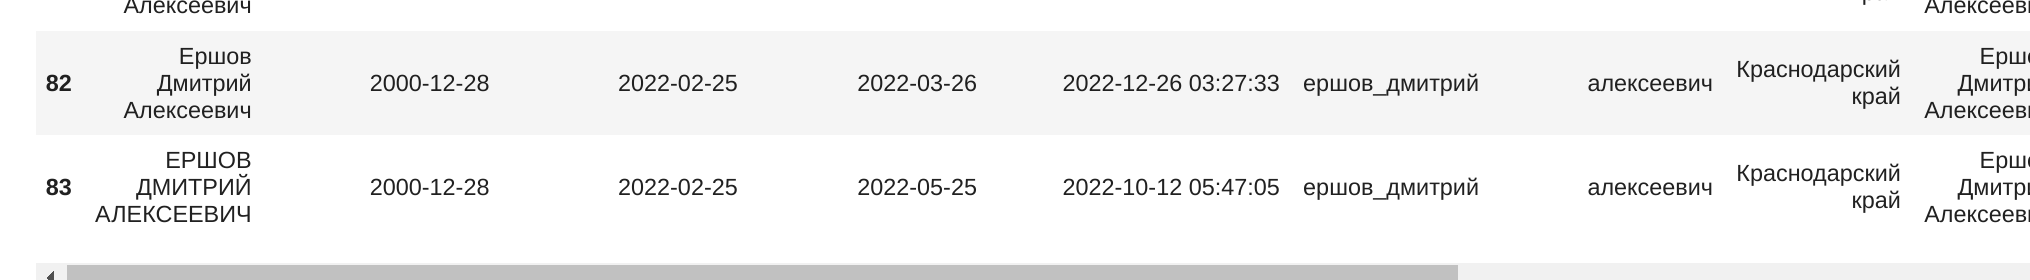

### 1.2 Unique to Parsed

#### 1.2.1 Calculating daily TailCoeffs from years 2014-2018

In [5]:
def flatten_cols_multiindex(df):
    df.columns=['_'.join(col).strip().strip('_') for col in df.columns.astype('str').values]
    return df

def parse_dates_with_mixed_formats(series,
                                   trim_extremes=True):
    '''
    Parses dates in columns where sometimes different date formats could be encountered.
    '''
    date_format_dict  = {r'\d\d\d\d-\d\d-\d\d'   :'%Y-%m-%d',
                         r'\d?\d\.\d\d\.\d\d\d\d':'%d.%m.%Y',
                         r'\d?\d/\d?\d/\d\d\d\d':"%m/%d/%Y"}
    
    series_index = series.index
    condlist = []; choicelist = []
    for regex, dateformat in date_format_dict.items():
        matches       = series.str.contains(re.compile(regex), na=False)
        parsed_series = pd.to_datetime(series, format=dateformat, errors='coerce')
        condlist.append(matches)
        choicelist.append(parsed_series)
    result = (pd
            .to_datetime(pd.Series(np.select(condlist,
                                             choicelist,
                                             default=pd.NaT
                                             ),
                                   index=series_index)
                        ).copy()
           )
    if trim_extremes:
        return result.pipe(lambda s_: s_.where((s_>='1850-01-01')&(s_<='2024-01-01'), pd.NaT))    
    else:
        return result

def add_IsoYearWeek(df, by_column='DeathDate'):
    return (df
            .assign(Year  = lambda df_: df_[by_column].dt.isocalendar()['year'],
                    Week  = lambda df_: df_[by_column].dt.isocalendar()['week'])
           )


def calculate_tail_coeffs_from_DeathActDate(in_path,
                                            out_path,
                                            ndays=365*3,
                                            nrows=100000,
                                            years_for_tail_calculation = [2014,2015,2016,2017,2018]):
    (
        pd
        .read_csv(in_path,
                  delimiter=';',
                  nrows=nrows,
                  usecols=['DeathDate', 'DeathActDate', 'CaseDate']
                 )
        .assign(
                    DeathDate    =lambda df_: parse_dates_with_mixed_formats(df_.DeathDate),
                    DeathActDate =lambda df_: parse_dates_with_mixed_formats(df_.DeathActDate),
                    CaseDate     =lambda df_: parse_dates_with_mixed_formats(df_.CaseDate),
                  )
        .assign(DaysToCase = lambda df_: (df_.CaseDate-df_.DeathActDate).dt.days)
        .loc[lambda df_: df_.DaysToCase >= 0]
        .pipe(add_IsoYearWeek)
        .loc[lambda df_: df_.Year.isin(years_for_tail_calculation)]
        .groupby(['Year','DaysToCase'])
        ['DeathDate']
        .count()
        .reset_index()
        .pivot(columns='Year', index='DaysToCase')
        .DeathDate
        .pipe(lambda df_: df_.div(df_.sum()).cumsum())
        .interpolate()
        .loc[0:ndays]
        .pipe(lambda df_: 1/df_)
        .assign(tail_coeffs     = lambda df_: df_.loc[:,years_for_tail_calculation].mean(axis=1),
                tail_coeffs_std = lambda df_: df_.loc[:,years_for_tail_calculation].std(axis=1))
        .loc[:,['tail_coeffs', 'tail_coeffs_std']]
        .pipe(lambda df_: df_.set_index(df_.index.astype(int).rename('DaysToRequest')))    
        .to_csv(out_path)
    )
    return None

In [9]:
%%time 
calculate_tail_coeffs_from_DeathActDate(filtered_path,tail_coeffs_path, nrows=None)

CPU times: user 1min 46s, sys: 6.76 s, total: 1min 53s
Wall time: 1min 53s


#### 1.2.2. Preparing patronim-to-sex mapping

The following classify record Fio's (full names) by the patronim used. Ground truth mapping is from the `full_base_plus_sex` table, wich was provided by third party (neural model).

In [6]:
def compose_patronims_sex_mapping(path_to_ground_truth=full_base_plus_sex,
                                  patronims_sex_mapping_path=patronims_sex_mapping_path,
                                  nrows=1000_000,
                                  patronim_regex=r'\b(\w+)\b\s*$',
                                  chunksize=100_000):
    reader = (pd
              .read_csv(path_to_ground_truth,
                        delimiter=';',
                        usecols=['Fio','sex'],
                        nrows=nrows,
                        chunksize=chunksize
                       )
             )
    df_collect = pd.DataFrame()
    for i, chunk in enumerate(reader):
        df_next = (chunk
                   .dropna(subset='sex')
                   .assign(sex = lambda df_: df_.sex.astype('uint8'))
                   .assign(Patronim = lambda df_: df_.Fio
                           .str.lower()
                           .str.extract(patronim_regex))
                   .drop(columns='Fio')
                   .groupby('Patronim')
                   .agg({'sex':['count', ('Sex', np.median)]})
                   .sex
                   .assign(Sex = lambda df_: df_.Sex.astype('uint8'))
                   .reset_index()
                   [['Patronim', 'Sex', 'count']]
                  )
        df_collect = pd.concat([df_collect,df_next], axis=0, ignore_index=True)
    (
        df_collect
        .sort_values(['Patronim', 'count'])
        .groupby(['Patronim','Sex'], as_index=False)
        .sum()
        .sort_values(['Patronim', 'count'], ascending=False)
        .groupby('Patronim', as_index=False)
        .first()
        .sort_values(['count'], ascending=False)
        .reset_index(drop=True)
        .to_csv(patronims_sex_mapping_path, index=False)
    )
    return None

In [11]:
%%time
compose_patronims_sex_mapping(nrows=None, chunksize=1_000_000)

CPU times: user 2min 54s, sys: 11.6 s, total: 3min 5s
Wall time: 3min 6s


#### 1.2.3 Parsing records

In [7]:
def add_Sex_drop_Fio(df, 
                     min_patronim_count=3,
                     drop=True):
    return (df
            .assign(Patronim = lambda df_: df_.Fio
                    .str.lower()
                    .str.extract(patronim_regex))
            .pipe(lambda df_: df_.drop(columns='Fio') if drop else df_)
            .merge(pd.read_csv(patronims_sex_mapping_path).loc[lambda df_: df_['count']>=min_patronim_count].drop(columns='count'),
                   on='Patronim',
                   how='left')
            .drop(columns='Patronim'))

def parse_dates_in_main_columns(df):
    return (df
            .assign(
                CaseIDDate   =lambda df_: pd.to_datetime(df_.CaseIDDate, errors='coerce'),
                download_time=lambda df_: pd.to_datetime(df_.download_time, errors='coerce'),
                BirthDate    =lambda df_: parse_dates_with_mixed_formats(df_.BirthDate),
                DeathDate    =lambda df_: parse_dates_with_mixed_formats(df_.DeathDate),
                DeathActDate =lambda df_: parse_dates_with_mixed_formats(df_.DeathActDate),
                CaseDate     =lambda df_: parse_dates_with_mixed_formats(df_.CaseDate),
              )

           )

def add_Age(df,
            col_name='Age',
            categorized=True,
            age_bins=[0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 120]):
    if not categorized:
        return (df
                .assign(**{col_name : lambda df_: (df_['DeathDate']-df_['BirthDate']).dt.days/365})                                                         
               )
    else:
        # cutting ages into bins
        # ROSSTAT: Возрастные интервалы включают значения точного возраста, входящего в данный интервал. 
        # Например, “20-24” обозначает пятилетний возрастной интервал от 20 до 24 лет включительно, 
        # т.е. интервал от точного возраста 20 до точного возраста 25 лет.
        # https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.cut.html
        # 95+ interval is treated as open like in HMD (actually, 95-120)
        # unlike HMD, there is no separate 0-1 category    
        age_labels = [str(i) for i in age_bins][:-1]
        return (df
                .assign(**{col_name : lambda df_: (df_['DeathDate']-df_['BirthDate']).dt.days/365})
                .assign(**{col_name : lambda df_: pd.cut(df_[col_name], 
                                                         age_bins, 
                                                         right=False,
                                                         include_lowest=True,
                                                         labels=age_labels)}) # intevals are half-closed - [..)
               )

def add_Delay(df, DelayThresholdDays=DelayThresholdDays):
    return (df
            .assign(DelayDays = lambda df_: (df_['DeathActDate']-df_['DeathDate']).dt.days.astype(float),
                    Delay     = lambda df_: np.select([df_.DelayDays>DelayThresholdDays,
                                                       df_.DelayDays<=DelayThresholdDays],
                                                      [True,False],
                                                      default=np.nan)
                   )
            .drop(columns='DelayDays')
           )

def add_CaseWeight_from_tail_coeffs(df, 
                                    tail_coeffs_path=tail_coeffs_path,
                                    last_request_date=last_request_date):
    return ( df
            .assign(DeathActDateToRequestDays = lambda df_: (pd.to_datetime(last_request_date)-df_.DeathActDate).dt.days)
            .merge(pd.read_csv(tail_coeffs_path)[['DaysToRequest','tail_coeffs']],
                   left_on='DeathActDateToRequestDays',
                   right_on='DaysToRequest',
                   how='left')
            .assign(CaseWeight = lambda df_: df_.tail_coeffs.fillna(1))
            .drop(columns=['DeathActDateToRequestDays','DaysToRequest','tail_coeffs'])
           )

def is_valid_DeathActNumber(DeathActNumber):
    '''
    raw DeathActNumber Series --> bool Series
    Source on the number structure and control digits:
    https://base.garant.ru/72087196/
    '''

    def series_to_array(Series):
    #   elements should look like '170219220006602454002'
    #   nans are not allowed
        result = np.array([i[1:-1] for i in Series.str.split('')],
                          dtype=int)
        return result

    def check_control_digit(Series):
        arr  = series_to_array(Series)
        mask = np.array([1,2,1,2,1,2,1,2,1,2,1,2,1,2,1,2,1,2,1,2])
        sums =(np.where((  arr[:,:-1]*mask)<9, # if
                           arr[:,:-1]*mask,    # then
                           arr[:,:-1]*mask-9   # else
                        )  
                  .sum(axis=1)
              )
        true_control_digits = 10 - np.divmod(sums, 10)[1]
        return pd.Series(arr[:,-1] == true_control_digits)

    return     pd.Series(np.where(DeathActNumber.str.fullmatch(r'_\d{21}', na=False), # if
                                  DeathActNumber.str.extract(  r'(\d{21})') 
                                                [0]
                                                .fillna('000000000000000000000')
                                                .pipe(check_control_digit), # then
                                  False                                     # else
                                 )
                        )

def extract_and_drop_DeathActNumber(df):
    return (df
            .assign(HasValidDeathActNumber=lambda df_: df_.DeathActNumber.pipe(is_valid_DeathActNumber),
                    MyZagsID    = lambda df_: pd.Series(np.where(df_.HasValidDeathActNumber,
                                                                 df_.DeathActNumber.str.extract('_\d{5}(\d{8})\d{8}', expand=False),
                                                                 np.nan)).astype('category'),
                    MyZagsCount = lambda df_: pd.Series(np.where(df_.HasValidDeathActNumber,
                                                                 df_.DeathActNumber.str.extract('_\d{13}(\d{5})\d{3}', expand=False).astype(float),
                                                                 np.nan)),
              )
            .drop(columns='DeathActNumber')
           )

def add_HasMonotonousDates(df):
    '''
    Adds boolean column with True if 
    BirthDate, DeathDate, DeathActDate, CaseDate, CaseIDDate, download_time
    are monotonous. NaNs are allowed.
    '''
    s= (df
       [['BirthDate', 'DeathDate', 'DeathActDate', 'CaseDate', 'CaseIDDate','download_time']]
       .ffill(axis=1)
       .fillna(pd.to_datetime(pd.Timestamp.min))
       .pipe(lambda df_:                                     
             (df_.BirthDate   <=df_.DeathDate)
            &(df_.DeathDate   <=df_.DeathActDate)
            &(df_.DeathActDate<=df_.CaseDate)
            &(df_.CaseDate    <=df_.CaseIDDate)
            &(df_.CaseIDDate  <=df_.download_time)
            )
       )
    return df.assign(HasMonotonousDates = s)

def replace_nans_in_Age_with_categories(df):
    return (df
            .assign(Age = lambda df_: df_.Age
                    .astype('str')
                    .str.replace('nan','u', regex=False)
                    .astype('category'))
           )

def replace_floats_in_Sex_with_categories(df):
    return (df
            .assign(Sex = lambda df_: df_.Sex
                    .fillna(-100)
                    .astype('str')
                    .str.replace('-100.0','u', regex=False)                    
                    .str.replace('1.0','m', regex=False)
                    .str.replace('0.0','f', regex=False)
                    .astype('category'))
           )

def replace_floats_in_Delay_with_categories(df):
    return (df
            .assign(Delay = lambda df_: df_.Delay
                    .fillna(-100)
                    .astype('str')
                    .str.replace('-100.0','u', regex=False)
                    .str.replace('1.0','late', regex=False)
                    .str.replace('0.0','early', regex=False)
                    .astype('category'))
           )

def replace_nans_in_ZagzID_with_categories(df):
    return (df
            .assign(MyZagsID = lambda df_: df_.MyZagsID
                    .astype('str')
                    .str.replace('nan','u', regex=False)
                    .astype('category'))
           )

In [8]:
last_request_date

'2023-06-26'

In [14]:
%%time
usable_cols = ['Fio', 
               'BirthDate', 'DeathDate',
               'DeathActDate', 'DeathActNumber',
               'CaseDate','CaseIDDate',
               'download time']

nrows=None
chunksize=200_000

reader = (pd
          .read_csv(filtered_path,
                    delimiter=';',
                    nrows=nrows,
                    chunksize=chunksize,
                    usecols=usable_cols))

df_collect = pd.DataFrame()

for i, chunk in enumerate(reader):
    df = (chunk
          .rename(columns=lambda c: c.replace(' ', '_'))
          .pipe(add_Sex_drop_Fio, min_patronim_count=3, drop=True)
          .pipe(parse_dates_in_main_columns)
          .pipe(add_IsoYearWeek)
          .pipe(add_Age)
          .pipe(add_Delay)
          .pipe(add_CaseWeight_from_tail_coeffs)
          .pipe(extract_and_drop_DeathActNumber)
          .pipe(add_HasMonotonousDates)
         )
    df_collect = pd.concat([df_collect, df], axis=0, ignore_index=True)
    print(f'I: {i}, memsize:{df_collect.pipe(lambda df_: df_.memory_usage(deep=True).sum()/(1024**2))}')

# writing down    
(
    df_collect
    .dropna(axis=0, subset='DeathDate') # this is the only place where we drop records from the Unique table
    .pipe(replace_nans_in_Age_with_categories)
    .pipe(replace_floats_in_Sex_with_categories)
    .pipe(replace_floats_in_Delay_with_categories)
    .pipe(replace_nans_in_ZagzID_with_categories)
    .sort_values(['Year', 'Week', 'Sex', 'Age', 'Delay'], ascending=False)
    .reset_index(drop=True)
    .to_parquet(parsed_table_path)
)

I: 0, memsize:17.931017875671387
I: 1, memsize:47.685617446899414
I: 2, memsize:71.52747535705566
I: 3, memsize:95.36936473846436
I: 4, memsize:119.21138000488281
I: 5, memsize:143.0532693862915
I: 6, memsize:166.89519023895264
I: 7, memsize:190.7371425628662
I: 8, memsize:214.5791893005371
I: 9, memsize:238.42114162445068
I: 10, memsize:262.26331424713135
I: 11, memsize:286.10529804229736
I: 12, memsize:309.94718742370605
I: 13, memsize:333.7892026901245
I: 14, memsize:357.6310920715332
I: 15, memsize:381.4729814529419
I: 16, memsize:405.3149652481079
I: 17, memsize:429.1569490432739
I: 18, memsize:452.9988384246826
I: 19, memsize:476.84075927734375
I: 20, memsize:500.68264865875244
I: 21, memsize:524.5245380401611
I: 22, memsize:548.3664274215698
I: 23, memsize:572.2084112167358
I: 24, memsize:596.0503950119019
I: 25, memsize:619.8924417495728
I: 26, memsize:643.7344570159912
I: 27, memsize:667.5765037536621
I: 28, memsize:691.4186449050903
I: 29, memsize:715.2608804702759
I: 30, mem

## 2. Analysis

### 2.1 Parsed to aggregated. Adding baselines

#### 2.1.1 Adding demographic data that could be used in predictors (optional)

Here we use two sources of demographic data that could be used (or not used) as a predictors for cases of inheritance.
There are:
- Historical Rosstat data on male and female deaths spanning from 2014 to 2021.
- Demographic projections from an independent demographer "Source-1"

In [9]:
### Funcs to add Rosstat and modeled Population Data

def download_Rosstat_files(url_dict, target_directory=None):
    for key, url in url_dict.items():
        # Extract the file name from the URL
        file_name = f'{key}_{url.split("/")[-1]}'
        
         # Set the target directory
        if target_directory is not None:
            os.makedirs(target_directory, exist_ok=True)
            file_path = os.path.join(target_directory, file_name)
        else:
            file_path = file_name

        # Send a GET request to the URL
        response = requests.get(url)

        # Check if the request was successful
        if response.status_code == 200:
            # Open a file in binary mode and write the response content
            with open(file_path, "wb") as file:
                file.write(response.content)
            print(f"File {file_name} downloaded successfully.")
        else:
            print(f"Failed to download file from {url}.")

In [29]:
Rosstat_mortality_sources = {'2016':'https://gks.ru/bgd/regl/B17_16/IssWWW.exe/Stg/5.1.xls', 
                             '2019':'https://gks.ru/bgd/regl/B19_16/IssWWW.exe/Stg/5.1.xls',
                             '2021':'https://gks.ru/bgd/regl/B21_16/IssWWW.exe/Stg/5.1.xlsx'}
download_Rosstat_files(Rosstat_mortality_sources, target_directory='data/in/Rosstat')

File 2016_5.1.xls downloaded successfully.
File 2019_5.1.xls downloaded successfully.
File 2021_5.1.xlsx downloaded successfully.


In [10]:
def parse_rosstat(df):
    
    rosstat_rename_age_dict = dict(zip(
        ['Всего\nTotal  ', '0', '1-4', '5-9', '10-14', '15-19', '20-24',
         '25-29', '30-34', '35-39', '40-44', '45-49', '50-54', '55-59',
         '60-64', '65-69', '70-74', '75-79', '80-84',
         '85 и более\n85 and over', 'Не указан\nNot stated'],
        ['total', '0', '1', '5', '10', '15', '20',
         '25', '30', '35', '40', '45', '50', '55',
         '60', '65', '70', '75', '80',
         '85', 'u']
    ))    
    return (df
            .iloc[2:23,[0, 5,6,7,8,9,10,11,12]]
            .rename(columns=({'Возраст, лет':'Age','Возраст, лет\nAge, years':'Age' }))
            .set_index(('Age', 'Unnamed: 0_level_1'))
            .stack(level=0)
            .reset_index()
            .rename(columns={('Age', 'Unnamed: 0_level_1'):'Age',
                             'level_1':'Sex'})
            .assign(Age = lambda df_: df_['Age'].replace(rosstat_rename_age_dict).astype('str'))
            .assign(Sex = lambda df_: df_['Sex'].replace({'Женщины\nFemales':'f','Мужчины\nMales':'m','Женщины':'f','Мужчины':'m'}))
            .set_index(['Age', 'Sex'])
            .stack()
            .reset_index()
            .rename(columns={'level_2':'Year', 0:'RosstatDeaths'})
           )

def redistribute_unknowns_in_rosstat(df):
    
    unknown = df.loc[df['Age']=='u', 'RosstatDeaths'].values
    total   = df.loc[df['Age']=='total', 'RosstatDeaths'].values

    df = (df
          .loc[lambda df_: (df_['Age']!='total')&(df_['Age']!='u')]
          .assign(RosstatDeaths = lambda df_: df_['RosstatDeaths']+(
                                                                      df_['RosstatDeaths']/df_['RosstatDeaths'].sum()
                                                                    )*unknown)
          .drop(columns=['Year', 'Sex'])
          .set_index('Age')
         )
    assert abs(df['RosstatDeaths'].sum()-total)<3
    return df


def get_rosstat_df():
    
    rosstat_2016 = (
        pd
        .read_excel('data/in/Rosstat/2016_5.1.xls', header=[2,4])
        .pipe(parse_rosstat)
        .assign(ReportYear = '2016'))

    rosstat_2019 = (
        pd
        .read_excel('data/in/Rosstat/2019_5.1.xls', header=[2,3])
        .pipe(parse_rosstat)
        .assign(ReportYear = '2019'))

    rosstat_2021 = (
        pd
        .read_excel('data/in/Rosstat/2021_5.1.xlsx', header=[2,3])
        .pipe(parse_rosstat)
        .assign(ReportYear = '2021'))

    rosstat = (
        pd
        .concat([rosstat_2016, rosstat_2019, rosstat_2021])
        .sort_values(['ReportYear'])
        .groupby(['Year', 'Age', 'Sex'])
        .last()
        .reset_index()
        .drop(columns='ReportYear')
        .groupby(['Year', 'Sex'])
        .apply(redistribute_unknowns_in_rosstat)
        .reset_index())
    return rosstat

def get_PopulationModeledDeaths_df():
    age_bins=[0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 120]
    age_labels = [str(i) for i in age_bins][:-1]

    return (
            pd
            .read_excel(demographic_projections_path,
                       sheet_name='LTm')
            .loc[216:421]
            .drop([317, 318, 319])
            .assign(Sex = lambda df_: np.where(df_.index>=320, 'f', 'm'))
            .rename(columns={'Средний вариант(2018)':'Age'})
            .set_index(['Age', 'Sex'])
            .stack()
            .reset_index()
            .rename(columns={'level_2':'Year', 0:'ModeledDeaths'})
            .assign(Age_cohort = lambda df_: pd.cut(df_['Age'], 
                                              age_bins, 
                                              right=False,
                                              include_lowest=True,
                                              labels=age_labels).astype('str'))
            .groupby(['Year', 'Sex', 'Age_cohort'], as_index=False)
            ['ModeledDeaths']
            .sum()
            .rename(columns={'Age_cohort':'Age'}))    
    

def get_deaths_df(rosstat, PopulationModeledDeaths):
    return (rosstat
            .merge(PopulationModeledDeaths, 
                   on=['Year', 'Sex', 'Age'],
                   how='outer')
            .assign(Deaths = lambda df_: np.where(df_['ModeledDeaths'].notna(),
                                                  df_['ModeledDeaths'],
                                                  df_['RosstatDeaths']))
            [['Year', 'Sex', 'Age', 'Deaths']])

def add_deaths(df):
    return (df
            .merge(get_deaths_df(get_rosstat_df(), get_PopulationModeledDeaths_df()),
                  on=['Year', 'Sex', 'Age'],
                  how='left')
           )

#### 2.1.2 Adding all baselines

In [11]:
def add_ToBeAggregated(df):
    '''
    Adds boolean column marking whether this record will be added to aggregated cases table.
    We need this in order to introspect records with invalid dates.
    - Discardes extreme dates
    - Discardes non-monotonous dates (i.e. typos)
    - Discardes very recent dates (i.e. less than 30d to collection)
    '''
    return (df
            .assign(ToBeAggregated = lambda df_: np.where(
                                                             (df_['DeathDate']>=first_date_in_SubSample)
                                                            &(df_['DeathDate']<=last_date_in_SubSample)
                                                            &(df_['HasMonotonousDates'])
                                                            &(np.where(
                                                                df_['DeathActDate'].notna(),
                                                                df_['DeathActDate'],
                                                                df_['DeathDate']
                                                                    )<=last_valid_date_in_analysis),
                                                        True,
                                                        False
                                                        )
                   )
           )

def redistribute_unknows(df):
    '''TODO'''
    all_aggregated_cases = df['Cases'].sum()
    all_aggregated_cases_whithout_unknowns = (
        df
        .loc[(df['Age']!='u')&(df['Sex']!='u')&(df['Delay']!='u')]
        ['Cases']
        .sum()
    )
    print(f'''
    all_aggregated_cases:\t{all_aggregated_cases},\n
    all_aggregated_cases_whithout_unknowns:\t{all_aggregated_cases_whithout_unknowns}.\n
    share of unknowns:\t{(all_aggregated_cases-all_aggregated_cases_whithout_unknowns)/all_aggregated_cases*100:.2f}%
          ''')
    # !! TO BE REPLACED WITH REDISTRIBUTION FUNCTION
    result = df.loc[(df['Age']!='u')&(df['Sex']!='u')&(df['Delay']!='u')].reset_index(drop=True)

    return result

def exclude_nonexistent_weeks_using_isocalendar(df, start_date, end_date):
    '''
    df --> df
    needed to exclude "ghost" 53th week in years where there are none     
    '''
    df_calendar = (
        pd
        .DataFrame({'Date':pd.date_range(start_date, end_date, freq='W')})
        .assign(Year = lambda df_: df_.Date.dt.isocalendar()['year'],
                Week = lambda df_: df_.Date.dt.isocalendar()['week'])
        [['Year', 'Week']])
    return (df
            .merge(df_calendar, 
                   on=['Year', 'Week'],
                   how='inner'))

def year_week_is_in_datespan(df, 
                             start_date='2014-01-01', 
                             end_date  ='2025-01-01'):
    '''
    Takes DataFrame with columns Year and Week and returns boolean Series. 
    Values are: True if Year and Week is in the span, else are False.
    '''
    calendar_df = (pd
                   .DataFrame({'Date':pd.date_range(start_date, end_date, freq='D')})
                   .pipe(add_IsoYearWeek, by_column='Date')
                   [['Year', 'Week']]
                   .drop_duplicates()
                   .reset_index(drop=True))
    
    Series = (pd
              .merge(df,
                     calendar_df,
                     on=['Year', 'Week'], 
                     how='left',
                     indicator=True)
              ['_merge']=='both')
    return Series

def add_Split(df, 
              train_set_last_date='2020-12-31', 
              test_set_last_date='2021-12-31'):
    return (df
            .assign(Split = np.select([year_week_is_in_datespan(df, end_date=train_set_last_date),
                                       year_week_is_in_datespan(df, start_date=train_set_last_date, end_date=test_set_last_date),
                                       year_week_is_in_datespan(df, start_date=test_set_last_date)],
                                      ['train', 'test', 'predict' ],
                                      default='ERROR')))


In [12]:
### BASELINES

#### Baseline 1 (Previous Year)

def add_baseline_1(df,
                   col = 'Cases_adj',
                   baseline_name='baseline_1'
                  ):
#     df-->df, adds a column with values of previous year for corresponing groups
    grouping_cols = ['Year', 'Week', 'Sex', 'Age']
    if 'Delay' in df.columns:
        grouping_cols.append('Delay')
    # return grouping_cols
    return ( df
            .merge(df
                       .assign(Year = lambda df_: df_.Year+1)
                       .rename(columns={col:baseline_name})
                       .loc[:,grouping_cols+[baseline_name]],
                   on=grouping_cols,
                   how='left')
        )

#### Baseline 2 (Mean of 5 years)

def add_baseline_2(df, 
                   cases='Cases_adj'):
    
    grouping_columns = ['Week', 'Sex', 'Age']
    if 'Delay' in df.columns:
        grouping_columns.append('Delay')
    df_prediction = (df
                    .loc[lambda df_: df_['Split'] == 'train']
                    .groupby(grouping_columns)
                    [cases]
                    .agg([('baseline_2', 'mean'), ('baseline_2_std','std')])
                    .reset_index()
                    )
    return (df
           .merge(df_prediction,
                  on=grouping_columns,
                  how='left')
           )

#### Baseline 3 (Linear model with predictors Year and Week)

def get_regression_df_for_cohort_for_baseline_3(df,
                                                cohort,
                                                smoothing_window=3):
    '''TODO'''
    return (df
            # .pipe(add_CovidCasesOWID)
            [['Year', 'Week', 'Sex', 'Age', 'Delay', 'Cases_adj', 'IsWar','Split']]
            .loc[lambda df_: (df_['Sex']==cohort[0])&(df_['Age']==cohort[1])&(df_['Delay']==cohort[2])]
            .sort_values(['Year', 'Week'])
            .reset_index(drop=True))

def add_baseline_3(df, 
                   smoothing_window=3):
    '''TODO'''
    cohorts = df.set_index(['Sex', 'Age', 'Delay']).index.drop_duplicates()
    df_collect = pd.DataFrame([])
    for cohort in cohorts:
        cohort_df = get_regression_df_for_cohort_for_baseline_3(df, cohort, smoothing_window) 
        X_train = (cohort_df
                   .loc[lambda df_: df_.Split=='train']
                   [['Year', 'Week']] # add 'CovidCasesOWID'
                   .pipe(pd.get_dummies, columns=['Week']))
        y_train = (cohort_df
                   .loc[lambda df_: df_.Split=='train']
                   [['Cases_adj']])
        X_all   = (cohort_df
                   [['Year', 'Week']] # add 'CovidCasesOWID'
                   .pipe(pd.get_dummies, columns=['Week']))
        
        pipe = Pipeline([("scale", StandardScaler()),
                         ("model", LinearRegression())])        
        prediction = pipe.fit(X_train, y_train).predict(X_all)
        
        cohort_df = (cohort_df
                     .assign(baseline_3=prediction))
        df_collect = pd.concat([df_collect,
                                cohort_df])    
    return pd.merge(df,
                    df_collect[['Year', 'Week', 'Sex', 'Age', 'Delay', 'IsWar','Split', 'baseline_3']],
                    on=['Year', 'Week', 'Sex', 'Age', 'Delay', 'IsWar','Split'],
                    how='left' )

#### Baseline 4 (Linear model with predictors Year Week and Cases for females 'Cases_adj_f')

def add_Cases_adj_f(df):
    return (df
            .merge(df
                        .set_index('Sex')
                        .loc['f']
                        [['Year','Week', 'Age', 'Delay', 'Cases_adj']]
                        .rename(columns={'Cases_adj':'Cases_adj_f'}),
                   on=['Year','Week', 'Age', 'Delay'],
                   how='left'
                  )
            .assign(Cases_adj_f = lambda df_: df_['Cases_adj_f'].mask(df_['Sex']=='f'))
)

def get_regression_df_for_cohort_for_baseline_4(df,
                                                cohort,
                                                smoothing_window=3):
    '''TODO'''
    return (df
            # .pipe(add_CovidCasesOWID)
            # .pipe(add_deaths)
            [['Year', 'Week', 'Sex', 'Age', 'Delay', 'Cases_adj', 'IsWar','Split', 'Deaths']]
            .pipe(add_Cases_adj_f)
            .loc[lambda df_: (df_['Sex']=='m')&(df_['Age']==cohort[0])&(df_['Delay']==cohort[1])]
            .assign(Deaths = lambda df_: df_['Deaths'].fillna(df_['Deaths'].mean()))
            .sort_values(['Year', 'Week'])
            .reset_index(drop=True))

def add_baseline_4(df, 
                   smoothing_window=3):
    '''TODO'''
    cohorts = df.set_index(['Age', 'Delay']).index.drop_duplicates()
    df_collect = pd.DataFrame([])
    for cohort in cohorts:
        cohort_df = get_regression_df_for_cohort_for_baseline_4(df,cohort, smoothing_window) 
        X_train = (cohort_df
                   .loc[lambda df_: df_.Split=='train']
                   [['Year', 'Week', 'Cases_adj_f', 'Deaths']] # add 'CovidCasesOWID'
                   .pipe(pd.get_dummies, columns=['Week']))
        y_train = (cohort_df
                   .loc[lambda df_: df_.Split=='train']
                   [['Cases_adj']])
        X_all   = (cohort_df
                   [['Year', 'Week', 'Cases_adj_f', 'Deaths']] # add 'CovidCasesOWID'
                   .pipe(pd.get_dummies, columns=['Week']))
        
        pipe = Pipeline([("scale", StandardScaler()),
                         ("model", LinearRegression())])        
        prediction = pipe.fit(X_train, y_train).predict(X_all)
        
        cohort_df = (cohort_df
                     .assign(baseline_4=prediction))
        df_collect = pd.concat([df_collect,
                                cohort_df])    
    return pd.merge(df,
                    df_collect[['Year', 'Week', 'Sex', 'Age', 'Delay', 'IsWar','Split', 'baseline_4']],
                    on=['Year', 'Week', 'Sex', 'Age', 'Delay', 'IsWar','Split'],
                    how='left' )

#### Baseline 5 (Linear model with predictors Year Week and female cases, BUT here we predict m-to-f ratio, not male cases)

def get_regression_df_for_cohort_for_baseline_5(df,
                                                cohort,
                                                smoothing_window=3):
    '''TODO'''
    return (df
            [['Year', 'Week', 'Sex', 'Age', 'Delay', 'Cases_adj', 'IsWar','Split', 'Deaths']]
            .pipe(add_Cases_adj_f)
            .loc[lambda df_: (df_['Sex']=='m')&(df_['Age']==cohort[0])&(df_['Delay']==cohort[1])]
            
            .assign(m_to_f_ratio = lambda df_: ( (df_['Cases_adj']  .rolling(smoothing_window, center=True, win_type='exponential').mean())
                                                /(df_['Cases_adj_f'].rolling(smoothing_window, center=True, win_type='exponential').mean()))
                    .replace([np.inf, -np.inf], np.nan)
                    # .interpolate()
                   )
            # .drop(columns=['Cases_adj_f'])
            .assign(Deaths = lambda df_: df_['Deaths'].fillna(df_['Deaths'].mean()))
            .sort_values(['Year', 'Week'])
            .reset_index(drop=True)            
           )

def add_baseline_5(df, 
                   smoothing_window=3):
    '''TODO'''
    cohorts = df.set_index(['Age', 'Delay']).index.drop_duplicates()
    df_collect = pd.DataFrame([])
    for cohort in cohorts:
        cohort_df = get_regression_df_for_cohort_for_baseline_5(df,cohort, smoothing_window) 
        X_train = (cohort_df
                   .loc[lambda df_: df_.Split=='train']
                   [['Year', 'Week', 'Deaths']]
                   .pipe(pd.get_dummies, columns=['Week']))
        y_train = (cohort_df
                   .loc[lambda df_: df_.Split=='train']
                   [['m_to_f_ratio']]
                   .assign(m_to_f_ratio = lambda df_: df_['m_to_f_ratio'].fillna(df_['m_to_f_ratio'].mean())))
        X_all   = (cohort_df
                   [['Year', 'Week', 'Deaths']]
                   .pipe(pd.get_dummies, columns=['Week']))

        pipe = Pipeline([("scale", StandardScaler()),
                         ("model", LinearRegression())])        
        prediction = pipe.fit(X_train, y_train).predict(X_all)
        
        cohort_df = (cohort_df
                     .assign(m_to_f_ratio_prediction=prediction,
                            baseline_5=lambda df_: df_['m_to_f_ratio_prediction']
                             *(df_['Cases_adj_f'].rolling(smoothing_window, center=True, win_type='exponential').mean())))
        df_collect = pd.concat([df_collect,
                                cohort_df])
    
    return pd.merge(df,
                    df_collect[['Year', 'Week', 'Sex', 'Age', 'Delay', 'IsWar','Split', 'baseline_5']],
                    on=['Year', 'Week', 'Sex', 'Age', 'Delay', 'IsWar','Split'],
                    how='left' )


**Here we aggregate parsed table and add all baselines:**

In [13]:
last_valid_date_in_analysis

Timestamp('2023-05-27 00:00:00')

In [14]:
last_request_date

'2023-06-26'

In [43]:
%%time
main_df = (
    pd
    .read_parquet(parsed_table_path)
    .pipe(add_ToBeAggregated)
    .loc[lambda df_: df_['ToBeAggregated']==True]
    .groupby(['Year', 'Week', 'Sex', 'Age', 'Delay'])
    .agg({'DeathDate':'count', 'CaseWeight':'sum'})
    .rename(columns={'DeathDate':'Cases', 'CaseWeight':'Cases_adj'})
    .reset_index()
    .pipe(redistribute_unknows)
    .pipe(exclude_nonexistent_weeks_using_isocalendar, start_date='2014-01-01', end_date=last_valid_date_in_analysis)
    .assign(IsWar = lambda df_: year_week_is_in_datespan(df_, start_date='2022-02-24'))
    .pipe(add_Split)
    .pipe(add_deaths)
    .pipe(add_baseline_1)
    .pipe(add_baseline_2)
    .pipe(add_baseline_3)
    .pipe(add_baseline_4)
    .pipe(add_baseline_5, smoothing_window=1)
)
main_df


    all_aggregated_cases:	10127498,

    all_aggregated_cases_whithout_unknowns:	9742116.

    share of unknowns:	3.81%
          
CPU times: user 27.5 s, sys: 14.8 s, total: 42.3 s
Wall time: 21.2 s


Year  Week Sex Age  Delay  Cases   Cases_adj  IsWar    Split  \
0      2014     1   f   0  early      8    8.000000  False    train   
1      2014     1   f   0   late      4    4.000000  False    train   
2      2014     1   f  10  early      1    1.000000  False    train   
3      2014     1   f  10   late      0    0.000000  False    train   
4      2014     1   f  15  early      2    2.000000  False    train   
...     ...   ...  ..  ..    ...    ...         ...    ...      ...   
39195  2023    20   m  85   late      3   14.575200   True  predict   
39196  2023    20   m  90  early     57  245.869238   True  predict   
39197  2023    20   m  90   late      2    9.622525   True  predict   
39198  2023    20   m  95  early     11   46.766546   True  predict   
39199  2023    20   m  95   late      2    9.413282   True  predict   

             Deaths  baseline_1  baseline_2  baseline_2_std  baseline_3  \
0       6202.052618         NaN   10.571429        8.772251   22.016410   
1       6202.052618         NaN    3.428571        1.618347    4.438150   
2        742.724829         NaN    2.000000        1.154701    1.662552   
3        742.724829         NaN    1.000000        1.154701    0.967619   
4       1619.580558         NaN    5.000000        1.825742    3.900407   
...             ...         ...         ...             ...         ...   
39195  75905.952407   64.470705   53.062930       16.976650  101.354715   
39196  35109.908944  224.629743  213.571429       67.002132  417.349523   
39197  35109.908944   13.723091   17.893362       13.299013   51.982216   
39198  16233.429078   59.060218   38.285714       17.085221   79.522826   
39199  16233.429078    7.390686    3.000000        1.527525    9.593708   

       baseline_4  baseline_5  
0             NaN         NaN  
1             NaN         NaN  
2             NaN         NaN  
3             NaN         NaN  
4             NaN         NaN  
...           ...         ...  
39195   33.232211   17.870838  
39196  323.201158  334.982284  
39197   10.502718    1.686430  
39198  100.925451  105.488814  
39199    1.060574    0.000000  

[39200 rows x 16 columns]

<Axes: xlabel='Year,Week'>

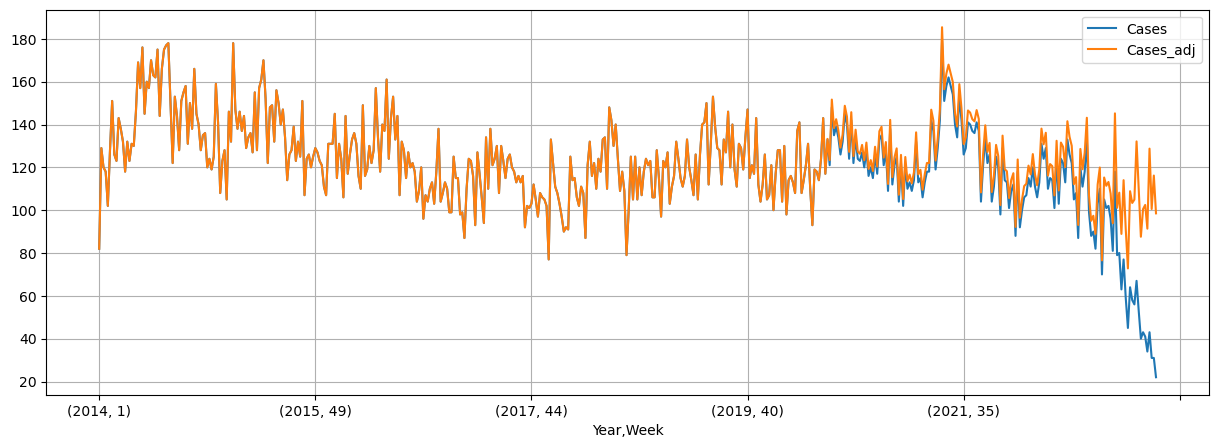

In [44]:
(
    main_df
    .pipe(exclude_nonexistent_weeks_using_isocalendar, start_date='2014-01-01', end_date=last_valid_date_in_analysis)
    .loc[lambda df_: (df_['Age']=='30')&(df_['Delay']=='early')&(df_['Sex']=='m')]
    .set_index(['Year', 'Week'])
    [['Cases', 'Cases_adj']]
    # .tail(150)
    .plot(figsize=(15,5), grid=True)

)

<Axes: xlabel='Year,Week'>

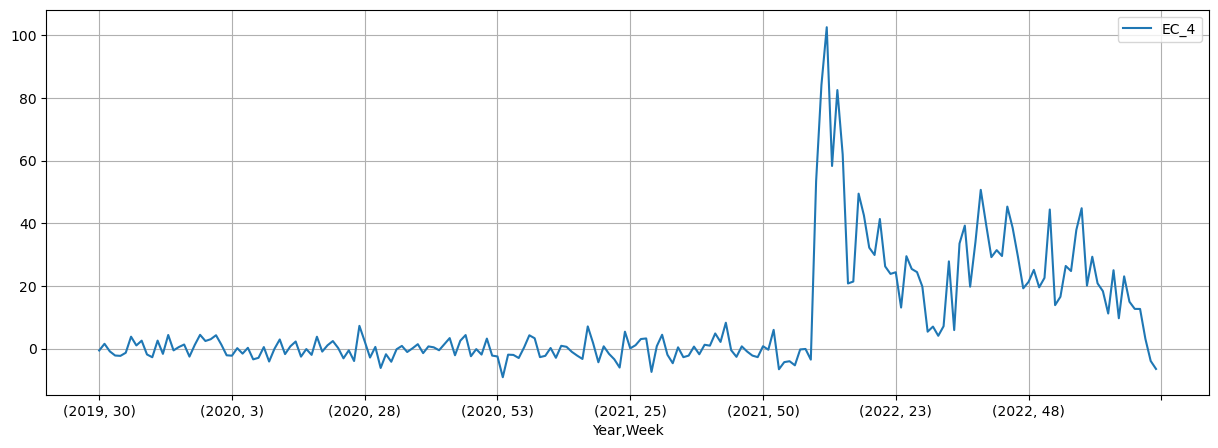

In [45]:
(
    main_df
    .loc[lambda df_: (df_['Age']=='20')&(df_['Delay']=='late')&(df_['Sex']=='m')]
    .reset_index(drop=True)
    .set_index(['Year', 'Week'])
    # .assign(EC_1       = lambda df_: df_['Cases_adj']-df_['baseline_1'])
    # .assign(EC_2       = lambda df_: df_['Cases_adj']-df_['baseline_2'])
    # .assign(EC_3       = lambda df_: df_['Cases_adj']-df_['baseline_3'])
    .assign(EC_4       = lambda df_: df_['Cases_adj']-df_['baseline_4'])
    # .assign(EC_5       = lambda df_: df_['Cases_adj']-df_['baseline_5'])
    # .pivot(columns=['Sex'], values=['EC_1', 'EC_2', 'EC_3', 'EC_4', 'EC_5'])
    .pipe(exclude_nonexistent_weeks_using_isocalendar, start_date='2014-01-01', end_date=last_valid_date_in_analysis)
    .set_index(['Year', 'Week'])
    [[
        # 'EC_1',
        # 'EC_2',
        # 'EC_3',
        'EC_4',
        # 'EC_5',
    ]]
    .tail(200)
    # .rolling(3, center=True, win_type='exponential').mean()
    .plot(figsize=(15,5), grid=True)
)

### 2.2 Calculating Case-to-Death coeffs from earliest records in Mediazona base (BMZ)

#### 2.2.1 Matching latest BMZ (wich contains RND data) with it's early snapshot (not having RND info) to find the share of persons who was finally found in RND

Funcs for BMZ

In [15]:
def guess_delimiter(file_path):
    with open(file_path, 'r') as file:
        first_line = file.readline().strip()
        dialect = csv.Sniffer().sniff(first_line, [',', ';', '\t'])
        return dialect.delimiter

def get_column_names_for_csv(path):
    return dict(enumerate(pd.read_csv(path, delimiter=guess_delimiter(path), nrows=0).columns))

def extract_year_from_string_series(series):
    return series.str.extract(r'((19|20)\d\d)', expand=False)[0]   

def parse_dates_to_month_precision(series, 
                                   valid_date_regex=r'(\d?\d?\.?\d?\d[\.\s](19|20)\d\d)',
                                   **kwargs):
    return (series
            .str.extract(valid_date_regex, expand=True)[0]
            .to_frame()
            .assign(day     = lambda df_: df_[0]
                                            .str.extract(r'(\d?[^\?]\d)(?=\.\d?\d[\.\s](19|20)\d\d)', expand=False)[0]
                                            .str.zfill(2)
                                            .mask(lambda d: (d.astype(float)<1)|(d.astype(float)>31)), # to get rid of "00" dates etc
                    month   = lambda df_: df_[0]
                                            .str.extract(r'(\d?\d)(?=[\.\s](19|20)\d\d)', expand=False)[0]
                                            .str.zfill(2),
                    year    = lambda df_: extract_year_from_string_series(df_[0]),
                    str_date= lambda df_: np.where((df_.month.notna()&df_.year.notna()),
                                                       (df_.year+'-'+df_.month+'-'+df_.day.fillna('01')),
                                                        np.nan
                                                   ),
                    guessed_date = lambda df_: pd.to_datetime(df_.str_date, dayfirst=True, errors='coerce')
            )
            .guessed_date)

def get_id2(Series):
    '''Series->Series'''
    return (Series
            .str.lower()
            .str.strip()
            .str.replace('ё','e')
            .to_frame()
            .assign(f =   lambda df_: df_.Fio.str.extract(r'^([\w,-]+)'), # first word in string
                    i =   lambda df_: df_.Fio.str.extract(r'\s([\w,-]+)'),# first word after space, no parentheses
                    id2 = lambda df_: df_.f+'_'+df_.i)
            ['id2'])

def add_IsoYearWeekPair(df, by_column='DeathDate'):
    """Adds a new column to a Pandas DataFrame with ISO year and week pairs based on a specified date column.
    Args:
        df (pandas.DataFrame): The DataFrame to modify.
        by_column (str): The name of the date column to use for calculating ISO year and week pairs. Default is 'DeathDate'.
    Returns:
        pandas.DataFrame: A modified DataFrame with a new column added containing ISO year and week pairs.
    """
    return (
        df.assign(
            YearWeek=lambda df_: np.where(df_[by_column].notna(),
                                         (
                                            df_[by_column]
                                            .dt.isocalendar()["year"]
                                            .astype("str")
                                            .str.zfill(4)
                                            + "_"
                                            + df_[by_column]
                                            .dt.isocalendar()["week"]
                                            .astype("str")
                                            .str.zfill(2)
                                        ),
                                         df_[by_column]
                                         )
            
        )
    )

def pick_one_random_match(df,
                          grouping_columns=['id2','YearWeek','Region']):
    return (df
            .assign(rand = lambda df_: np.random.rand(df_.shape[0]))
            .sort_values('rand')
            .groupby(grouping_columns, as_index=False)
            .first())

def get_binomial_error(n, n_s, z=1.96):
    '''Calculates a binomial error, see https://en.wikipedia.org/wiki/Binomial_proportion_confidence_interval
    n - stands for the number of trials,
    n_s - stands for the number of succeses'''
    # n = float(n)
    # n_s = float(n_s)
    return (
            (z * np.sqrt(n_s * (n - n_s)))
                 /
            (n * np.sqrt(n))
           )

def get_binomial_error_for_boolean(arr):
    return get_binomial_error(arr.count(), arr.sum()) if (arr.count()&arr.sum()) else np.NaN

def calculate_shares_for_given_filter(df, filter_col):
    return (df
            .loc[lambda df_: df_[filter_col]]
            .pipe(pick_one_random_match) # picks one valid random match from latest table to April's record
            .groupby(['Age_cohort'])
             ['InRND_latest']
            .agg(['count', 'sum'])
            .loc[lambda df_: df_['count']>10]
            .assign(Ratio = lambda df_: df_['sum']/df_['count'],
                    Ratio_BE = lambda df_: get_binomial_error(df_['count'].astype('float'), df_['sum'].astype('float')) 
                   )
           )

def plot_ratios_for_filters(df,
                            filters = ['f1', 'f2', 'f3', 'f4', 'f5']):

    frames = []
    for col in filters:
        frames.append(calculate_shares_for_given_filter(df, filter_col=col))
    return (pd.concat(frames, keys=filters)
            .unstack(level=0)
            .pipe(lambda df_: display(df_) or df_)
            .pipe(lambda df_: df_['Ratio'].plot.bar(yerr=df_['Ratio_BE'],
                                                    grid=True,
                                                    ylim=(0,1),
                                                    figsize=(10,5),
                                                    # title=title_to_plot
                                                   ),
                 )
           )

def add_Age_cohort(df,
                   col_name_input_age = 'Age',
                   col_name_age_rnd = 'Age_rnd',
                   col_name_age_publication = 'Age_publication',
                   col_name_age_selected = 'Age_selected',
                   col_name_age_cohort = 'Age_cohort',
                   last_possible_DeathDate = last_request_date):
    '''
    This is a specific function that guesses age for a person in BMZ given possible discrepancy beetween
    age as stated in RND and age stated in social network post.
    In chosing age precedence goes like this:
    1. Calculated from RND, if present
    2. Calculated from publications `BirthDate` & `DeathDate`, if present
    3. Taken from 'Age' column
    '''

    age_bins=[0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 120]
    age_labels = [str(i) for i in age_bins][:-1]
    return (df
            .pipe(add_Age, col_name=col_name_age_rnd, categorized=False)
            .assign(**{col_name_age_publication : lambda df_: np.where((df.DeathDate.notna()&df.BirthDate.notna()),
                                                                       ((df.DeathDate - df.BirthDate).dt.days/365).round(),
                                                                       ((pd.to_datetime(last_possible_DeathDate) - pd.to_datetime(df.BirthYear)).dt.days/365).round(),
                                                                      )
                       ,
                       col_name_age_selected    : lambda df_: np.where(df_[col_name_age_rnd].notna(),
                                                                       df_[col_name_age_rnd],
                                                                       np.where(df_[col_name_age_publication].notna(),
                                                                                df_[col_name_age_publication],
                                                                                df_[col_name_input_age]
                                                                               )
                                                                      )
                                                           .round(),
                       col_name_age_cohort : lambda df_: pd.cut(df_[col_name_age_selected], 
                                                                age_bins, 
                                                                right=False,
                                                                include_lowest=True,
                                                                labels=age_labels)
                      })
            .drop(columns={col_name_age_rnd,
                           # col_name_age_selected
                          })
           )



Reading latest BMZ snapshot

In [16]:
get_column_names_for_csv(bmz_latest_path)

{0: 'ФИО',
 1: 'регион',
 2: 'возраст',
 3: 'дата рождения',
 4: 'дата гибели',
 5: 'дата подтверждения гибели',
 6: 'комментарий',
 7: 'РВ МЗ',
 8: 'подразделение',
 9: 'сохраненные источники',
 10: 'google_id',
 11: 'номер в горюшке',
 12: 'Status',
 13: 'Created',
 14: 'BirthDate',
 15: 'DeathDate',
 16: 'DeathActDate',
 17: 'DeathActNumber',
 18: 'CaseDate'}

In [17]:
names_dict = {
0: 'Fio',
1: 'Region',
2: 'Age',
3: 'BirthDate',
4: 'DeathDate',
5: 'WebDate',
6: 'Comment',    
7: 'techfield_1',
8: 'techfield_2',
# 11: 'номер в горюшке',
12: 'Status',
13: 'Created',
14: 'BirthDate_rnd',
15: 'DeathDate_rnd',
16: 'DeathActDate_rnd',
17: 'DeathActNumber_rnd',
18: 'CaseDate_rnd'
}

bmz_latest = (
    pd
    .read_csv(bmz_latest_path,
              header=0,
              usecols=names_dict.keys(),
              names=names_dict.values())
    .assign(
        Age         =lambda df_: pd.to_numeric(df_['Age'], errors='coerce'),
        BirthYear   =lambda df_: extract_year_from_string_series(df_['BirthDate']),
        BirthDate   =lambda df_: parse_dates_with_mixed_formats(df_['BirthDate']),
        WebDate     =lambda df_: pd.to_datetime(df_['WebDate'], dayfirst=False),
        DeathDate   =lambda df_: parse_dates_to_month_precision(df_['DeathDate']),
        Created     =lambda df_: pd.to_datetime(df_['Created'], dayfirst=False),
        # is_convict  =lambda df_: (df_.techfield_1.str.contains(r'заключенные', na=False))
        #                        &(~df_.techfield_2.str.contains(r'\?', na=False))
        #                        &(~df_.techfield_2.str.contains(r'по месту захоронения', na=False)),
        InRND      = lambda df_: df_.DeathActDate_rnd.notna(),
        id2=lambda df_: get_id2(df_.Fio),
        Patronim=lambda df_: df_.Fio
                                            .str.lower()
                                            .str.strip()
                                            .str.replace('ё','e')
                                            .str.split(n=2, expand=True)[2],
    )
    # .loc[lambda df_: df_.Created<=bmz_last_date_created] # Dropping out all the records created after bmz_last_date_created
    .reset_index(drop=True)
    .pipe(add_IsoYearWeekPair)
     )
bmz_latest.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26682 entries, 0 to 26681
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Fio                 26682 non-null  object        
 1   Region              26682 non-null  object        
 2   Age                 11040 non-null  float64       
 3   BirthDate           16985 non-null  datetime64[ns]
 4   DeathDate           18889 non-null  datetime64[ns]
 5   WebDate             26009 non-null  datetime64[ns]
 6   Comment             16673 non-null  object        
 7   techfield_1         26532 non-null  object        
 8   techfield_2         15885 non-null  object        
 9   Status              26682 non-null  object        
 10  Created             26682 non-null  datetime64[ns]
 11  BirthDate_rnd       8288 non-null   object        
 12  DeathDate_rnd       8293 non-null   object        
 13  DeathActDate_rnd    8231 non-null   object    

Reading early (April) BMZ snapshot

In [18]:
dict(enumerate(pd.read_excel(bmz_snapshot_20220414_path).columns))    

{0: 'основной регион (тот из которого первым поступила официальная информация, если такой не определить, то регион, где проживает семья)',
 1: 'ФИО',
 2: 'возраст',
 3: 'дата рождения',
 4: 'звание',
 5: 'тип силовой структуры',
 6: 'должность',
 7: 'подразделение',
 8: 'дата гибели',
 9: 'место гибели',
 10: 'место жительства',
 11: 'место рождения',
 12: 'место захоронения',
 13: 'дата похорон',
 14: 'посмертные награды',
 15: 'дата появления официальной информации',
 16: 'источник 1',
 17: 'источник 2',
 18: 'источник 3',
 19: 'источник 4',
 20: 'источник 5',
 21: 'источник 6',
 22: 'сохраненные источники',
 23: 'личная страницы в социальной сети ',
 24: 'наличие мемориальной доски / памятника / стенда и т.д. (коммент + ссылка)',
 25: 'комментарий',
 26: 'не было в официальных источниках',
 27: 'Unnamed: 27',
 28: 'Unnamed: 28',
 29: 0}

In [19]:
names_dict = {0: 'Region',
             1: 'Fio',
             2: 'Age',
             3: 'BirthDate',
             # 4: 'звание',
             # 5: 'тип силовой структуры',
             # 6: 'должность',
             # 7: 'подразделение',
             8: 'DeathDate',
             # 9: 'место гибели',
             # 10: 'место жительства',
             # 11: 'место рождения',
             # 12: 'место захоронения',
             # 13: 'дата похорон',
             # 14: 'посмертные награды',
             15: 'WebDate'}

bmz_20220414 = (
    pd
    .read_excel(bmz_snapshot_20220414_path,
                header=0,
                usecols=names_dict.keys(),
                names=names_dict.values())
    .loc[lambda df_: df_.Fio.notna()].reset_index(drop=True)
    .assign(
        Age         =lambda df_: pd.to_numeric(df_['Age'], errors='coerce'),
        BirthYear   =lambda df_: extract_year_from_string_series(df_['BirthDate']),
        BirthDate   =lambda df_: parse_dates_to_month_precision(df_['BirthDate']),
        DeathDate   =lambda df_: parse_dates_to_month_precision(df_['DeathDate']),
        WebDate     =lambda df_: pd.to_datetime(df_['WebDate'], dayfirst=True, errors='coerce'),
        id2         =lambda df_: get_id2(df_.Fio),
        Patronim=lambda df_: df_.Fio
                                            .str.lower()
                                            .str.strip()
                                            .str.replace('ё','e')
                                            .str.split(n=2, expand=True)[2],
    )
    .pipe(add_Age_cohort).drop(['Age_publication', 'Age_selected'], axis=1).assign(Age_cohort = lambda df_: df_.Age_cohort.astype('str').replace('nan','NoAgeData'))
    .pipe(add_IsoYearWeekPair).assign(YearWeek = lambda df_: df_.YearWeek.fillna('NoYearWeek'))
     )

bmz_20220414.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1534 entries, 0 to 1533
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Region      1534 non-null   object        
 1   Fio         1534 non-null   object        
 2   Age         915 non-null    float64       
 3   BirthDate   417 non-null    datetime64[ns]
 4   DeathDate   582 non-null    datetime64[ns]
 5   WebDate     1474 non-null   datetime64[ns]
 6   BirthYear   419 non-null    object        
 7   id2         1534 non-null   object        
 8   Patronim    1080 non-null   object        
 9   Age_cohort  1534 non-null   object        
 10  YearWeek    1534 non-null   object        
dtypes: datetime64[ns](3), float64(1), object(7)
memory usage: 132.0+ KB


Region                      Fio   Age  BirthDate  DeathDate  \
258  Иркутская область  Гарбузов Иван Антонович  20.0 2022-02-12 2022-03-12   

       WebDate BirthYear            id2   Patronim Age_cohort YearWeek  
258 2022-03-21      2022  гарбузов_иван  антонович          0  2022_10

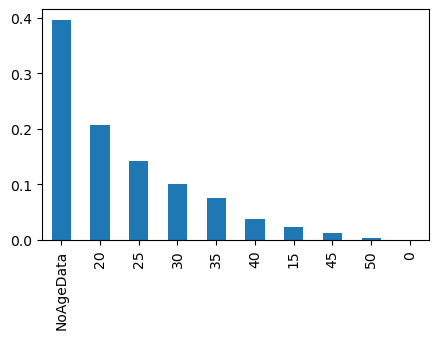

In [20]:
bmz_20220414.Age_cohort.value_counts(normalize=True).plot.bar(figsize=(5,3))
bmz_20220414.loc[lambda df_: df_.Age_cohort=='0']

Merging with latest, applying filters, calculating shares

In [21]:
# MERGING early and late table

# f0 - DeathDate_latest either before the snapshot date (20220414) or unknown
# f1 - no mismatch in Patronim 
# f2 - no mismatch in DeathDate
# f3 - no mismatch in BirthDate
# f4 - no mismatch in BirthYear
# f5 - f0&f1&f2&f3&f4

df_april_to_latest_merged = (
    bmz_20220414
    .merge(bmz_latest.add_suffix('_latest'),
           left_on='id2',
           right_on='id2_latest',
           how='left',
           indicator=True)
    .rename(columns={'_merge':'PresenceInTables'})
    .assign(f0 = lambda df_: df_.DeathDate_latest.isna()|(df_.DeathDate_latest<'2022-05-01'),
            f1 = lambda df_: df_.Patronim.isna()|df_.Patronim_latest.isna()|(df_.Patronim==df_.Patronim_latest),
            f2 = lambda df_: df_.DeathDate.isna()|df_.DeathDate_latest.isna()|((df_.DeathDate-df_.DeathDate_latest).dt.days.abs()<=3),
            f3 = lambda df_: df_.BirthDate.isna()|df_.BirthDate_latest.isna()|((df_.BirthDate-df_.BirthDate_latest).dt.days.abs()<=3),
            f4 = lambda df_: df_.BirthYear.isna()|df_.BirthYear_latest.isna()|(df_.BirthYear==df_.BirthYear_latest),
            f5 = lambda df_: df_.f0&df_.f1&df_.f2&df_.f3&df_.f4
           )
)

count                      sum                         Ratio  \
              f1   f2   f3   f4   f5   f1   f2   f3   f4   f5        f1   
Age_cohort                                                                
15            34   33   34   34   33   13   14   13   14   12  0.382353   
20           307  301  307  310  291  180  171  179  182  166  0.586319   
25           207  204  209  213  190  122  121  121  122  112  0.589372   
30           149  149  145  151  140   99   98   96  100   93   0.66443   
35           115  109  109  111  100   74   68   71   73   65  0.643478   
40            53   51   52   53   48   44   38   42   41   40  0.830189   
45            18   19   17   19   15   14   14   13   14   12  0.777778   
NoAgeData    570  563  582  582  550  348  346  364  350  343  0.610526   

                                                    Ratio_BE            \
                  f2        f3        f4        f5        f1        f2   
Age_cohort                                                               
15          0.424242  0.382353  0.411765  0.363636  0.163350  0.168627   
20          0.568106  0.583062  0.587097  0.570447  0.055092  0.055960   
25          0.593137  0.578947   0.57277  0.589474  0.067018  0.067413   
30          0.657718  0.662069  0.662252  0.664286  0.075819  0.076186   
35          0.623853  0.651376  0.657658      0.65  0.087542  0.090942   
40          0.745098  0.807692  0.773585  0.833333  0.101086  0.119609   
45          0.736842  0.764706  0.736842       0.8  0.192062  0.198004   
NoAgeData   0.614565   0.62543  0.601375  0.623636  0.040032  0.040203   

                                          
                  f3        f4        f5  
Age_cohort                                
15          0.163350  0.165431  0.164129  
20          0.055154  0.054809  0.056876  
25          0.066938  0.066434  0.069949  
30          0.076991  0.075435  0.078227  
35          0.089462  0.088272  0.093486  
40          0.107121  0.112674  0.105431  
45          0.201644  0.198004  0.202428  
NoAgeData   0.039323  0.039779  0.040490

<Axes: xlabel='Age_cohort'>

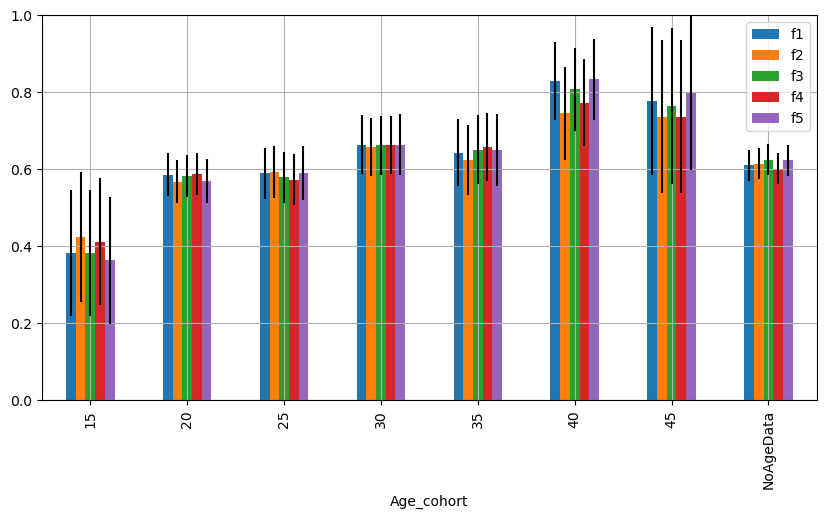

In [22]:
plot_ratios_for_filters(df_april_to_latest_merged, 
                        # ['f1', 'f5']
                       )

In [23]:
CTD_Coefs_Apr_auto_f5 = (   df_april_to_latest_merged
                            .pipe(calculate_shares_for_given_filter, filter_col='f5')
                            .reset_index()
                            .assign(Sex = 'm')
                            .rename(columns={'Age_cohort':'Age'})
                            [['Age', 'Sex', 'Ratio', 'Ratio_BE']]
                            .assign(CTD = lambda df_: 1/df_['Ratio'])
                        )
CTD_Coefs_Apr_auto_f5

Age Sex     Ratio  Ratio_BE       CTD
0         15   m  0.424242  0.168627  2.357143
1         20   m  0.570447  0.056876  1.753012
2         25   m  0.589474  0.069949  1.696429
3         30   m  0.671429  0.077805  1.489362
4         35   m      0.67  0.092162  1.492537
5         40   m    0.8125  0.110420  1.230769
6         45   m       0.8  0.202428      1.25
7  NoAgeData   m      0.62  0.040566  1.612903

Special function producing a table used to manually check all the matches (optional).

In [24]:
columns_in_manual_checking_table = [
'ToCheckManually',
'InRNDManually',
'CommentOnCheking',
'InRND_latest',
'Age_cohort', 
'PresenceInTables', 
'f5',
'Fio', 
'Fio_latest', 
'Comment_latest', 
'Region', 
'Region_latest', 
'DeathDate', 
'DeathDate_latest', 
'DeathDate_rnd_latest', 
'BirthDate', 
'BirthDate_latest', 
'BirthDate_rnd_latest', 
'WebDate', 
'WebDate_latest', 
'Age', 
'Age_latest', 
'BirthYear', 
'BirthYear_latest', 
'CaseDate_rnd_latest', 
'Created_latest', 
'DeathActDate_rnd_latest', 
'DeathActNumber_rnd_latest', 
'id2', 
'id2_latest', 
'is_convict_latest', 
'Patronim', 
'Patronim_latest', 
'Status_latest', 
'techfield_1_latest', 
'techfield_2_latest', 
'YearWeek', 
'YearWeek_latest', 
'f0', 
'f1', 
'f2', 
'f3', 
'f4',]

def compose_cheking_table_for_n_people_in_Apr(df, samplesize=100):
    '''
    df->df
    Takes merged table and samples samplesize number of people from early table,
    assignes wether a case should be cheked
    every candidate from the latest table for a one case in early table is present
    ones in the `InRNDManually` column are filled for every candidate -
    - so the sum of ones is generally greater than samplesize
    '''
    return (df
            [['id2', 'YearWeek', 'Region']]
            .groupby(['id2', 'YearWeek', 'Region'], as_index=False)
            .first()
            .assign(InRNDManually = False,
                    CommentOnCheking = '-',
                    ToCheckManually = lambda df_: generate_random_sample_array(size = df_.shape[0], n=samplesize))
            .merge(df_april_to_latest_merged,
                   on=['id2', 'YearWeek', 'Region'],
                   how='right')
            [columns_in_manual_checking_table]
            .sort_values(['Age_cohort', 'PresenceInTables', 'f5'])
            .reset_index(drop=True))

#### 2.2.2 How full is our RND sample when compared to RND web-service ? In other words, what share of all BMZ cases that were found in RND is present in our sample of RND?

##### 2.2.2.1 When **only correct** DeathActDates are concerned, what share of cases in Apr base could be found in our sample?

In [48]:
# 1. Take df_april_to_latest_merged, find records with valid DeathActDates, extract their digits, make separate DataFrame
# 2. Read all unique record stored at `filtered_path`, 
#    find those that match ONLY on this valid DeathActDates, collect them in df_collect 
# 3. Match records with valid DeathActDates mith found in RND Sample
# 4. Analyse those that were/won't found

DeathActNumbersForLatestBase = (bmz_latest
                                [['DeathActNumber_rnd']]
                                .loc[lambda df_: is_valid_DeathActNumber(df_['DeathActNumber_rnd'])]
                                .assign(ParsedDeathActNumber = lambda df_: df_['DeathActNumber_rnd'].str.extract(r'(\d+)')[0])
                                .dropna(subset='ParsedDeathActNumber'))

nrows=None
chunksize=100_000

reader = (pd
          .read_csv(filtered_path,
                    delimiter=';',
                    nrows=nrows,
                    chunksize=chunksize,
                    usecols=['DeathActNumber']))

df_collect = pd.DataFrame()

for i, chunk in enumerate(reader):
    df = (chunk
          .assign(ParsedDeathActNumber = lambda df_: df_['DeathActNumber'].str.extract(r'(\d+)')[0])
          .merge(DeathActNumbersForLatestBase,
                 on=['ParsedDeathActNumber'],                 
                 how='inner')
         )
    df_collect = pd.concat([df_collect, df], axis=0, ignore_index=True)

result = (pd
            .merge(DeathActNumbersForLatestBase,
                   df_collect,
                   on=['ParsedDeathActNumber'],
                   how='left',
                   indicator=True))

found = result['_merge'].value_counts()['both']
searched = result['_merge'].value_counts().sum()
info.update({'Cases in latest BMZ with valid DeathActDate':searched,
             'Cases in latest BMZ with valid DeathActDate found in RND unique sample':found,
             'Share of cases (valid) found in RND unique sample':found/searched})
info

{'Cases in latest BMZ with valid DeathActDate': 5674,
 'Cases in latest BMZ with valid DeathActDate found in RND unique sample': 5642,
 'Share of cases (valid) found in RND unique sample': 0.9943602396898131}

##### 2.2.2.2 When **all** DeathActDates are concerned, what share of cases in Apr base could be found in our sample?

In [49]:
df_AprInRND = (
                df_april_to_latest_merged
                .loc[lambda df_: df_['PresenceInTables']=='both']
                .loc[lambda df_: df_['InRND_latest']]
                [['id2', 'BirthDate_rnd_latest', 'DeathDate_rnd_latest']]
                .rename(columns={'BirthDate_rnd_latest':'BirthDate', 'DeathDate_rnd_latest':'DeathDate'})
                .assign(BirthDate   =lambda df_: parse_dates_with_mixed_formats(df_['BirthDate']),
                        DeathDate   =lambda df_: parse_dates_with_mixed_formats(df_['DeathDate'])))

nrows=None
chunksize=100_000

reader = (pd
          .read_csv(filtered_path,
                    delimiter=';',
                    nrows=nrows,
                    chunksize=chunksize,
                    usecols=['Fio', 'BirthDate', 'DeathDate',]))

df_collect = pd.DataFrame()

for i, chunk in enumerate(reader):
    df = (chunk
          .assign(BirthDate   =lambda df_: parse_dates_with_mixed_formats(df_['BirthDate']),
                  DeathDate   =lambda df_: parse_dates_with_mixed_formats(df_['DeathDate']),
                  id2=lambda df_: get_id2(df_.Fio))
          .merge(df_AprInRND,
                 on=['id2', 'BirthDate', 'DeathDate'],                 
                 how='inner')
         )
    df_collect = pd.concat([df_collect, df], axis=0, ignore_index=True)

result = (pd
          .merge(df_AprInRND,
                 df_collect,
                 on=['id2', 'BirthDate', 'DeathDate'],
                 how='left',
                 indicator=True))

found = result['_merge'].value_counts()['both']
searched = result['_merge'].value_counts().sum()
info.update({'Cases in Apr BMZ with matching id2, BirthDate, DeathDate':searched,
             'Cases in Apr BMZ with matching id2, BirthDate, DeathDate found in RND unique sample':found,
             'Share of Apr cases (matching id2, BirthDate, DeathDate) found in RND unique sample':found/searched})
info

{'Cases in latest BMZ with valid DeathActDate': 5674,
 'Cases in latest BMZ with valid DeathActDate found in RND unique sample': 5642,
 'Share of cases (valid) found in RND unique sample': 0.9943602396898131,
 'Cases in Apr BMZ with matching id2, BirthDate, DeathDate': 1148,
 'Cases in Apr BMZ with matching id2, BirthDate, DeathDate found in RND unique sample': 1117,
 'Share of Apr cases (matching id2, BirthDate, DeathDate) found in RND unique sample': 0.9729965156794426}

### 2.3 Assesing Case-to-Death coeffs for different military categories, matching known Apr military personell with convicts etc.

Excessive death equals excessive inheritance cases multiplied by Case-to-Death coefficient:
$$ ED^{Age} = EC^{Age} \times CDT^{Age} $$
where $CTD = 1/(Share of found in RND)$.

Different military cohorts present in any $Age$ cohort have different CTDs, they could be expressed via $MC_i$ coeffs:

$$CTD_{1}=CTD_0 \times MC_1$$

So $ED$ for particular $Age$ is: 

$$ ED_{all} = EC \times S_0 \times CTD_0 + EC \times S_1 \times CTD_1 + ... + EC \times S_n \times CTD_n$$

Which effectevely is:

$$ ED = EC \times CTD_0 (S_0 + S_1 \times MC_1 + ... + S_n \times MC_n)$$

and since $\sum_{i=0}^{n}S_i=1$:

$$ ED = EC \times CTD_0 (1 - \sum_{i=1}^{n}S_i + S_1 \times MC_1 + ... + S_n \times MC_n)$$

$$ ED = EC \times CTD_0 (1 - \sum_{i=1}^{n}S_i + \sum_{i=1}^{n} S_i \times MC_i)$$


The last multiplier will be named $MC_{coeff}$:

$$ ED^{Week,Age} = EC^{Week,Age} \times CTD_0^{Age} \times MC_{coeff}^{Week}$$


#### 2.3.1 How different are military cohorts in their propensity to get into RND? What are the most important to account for?

In [27]:
def get_matches(df, by_marker):
    '''
    Takes df with persons and matches persons in category specified by `by_marker` 
    to the persons in default category 'MC_0'
    '''
    
    cols_for_matching = ['Fio', 
                         'YearWeek', 
                         'Age_cohort', 
                         'DeathDate', 
                         'Region', 
                         'Age_selected', 
                         'DeathActDate_rnd', 
                         'InRND']
    
    result = (df
            .loc[lambda df_: (df_.Age_cohort.notna())&(df_.YearWeek.notna())]
            .pipe(lambda df_: pd.merge(df_.loc[df_[by_marker]==True][cols_for_matching+[by_marker]+['MC_0']],
                                       df_.loc[df_['MC_0']   ==True][cols_for_matching+[by_marker]+['MC_0']],
                                       on=['YearWeek', 'Age_cohort'],
                                       how='left',
                                       suffixes=('', '_matched')))
            .assign(matching_score = lambda df_: ((df_.DeathDate   ==df_.DeathDate_matched).astype('int')
                                                 +(df_.Region      ==df_.Region_matched).astype('int')
                                                 +(df_.Age_selected==df_.Age_selected_matched).astype('int')))
            .sort_values('matching_score', ascending=False)
            .groupby(['Fio','DeathDate'], as_index=False)
            .first()
             )

    return result

In [28]:
top_largest_military_cohorts = (
    bmz_latest['techfield_1']
    .value_counts()
    .iloc[1:]
    .pipe(lambda df_: 100*df_/df_.sum())
    .head(20)
)

def get_ratio_in_RND_for_cohort(df=bmz_latest,
                                cohort_name_in_techfield_1='заключенные'):
    return (
        df
        .pipe(add_Age_cohort)
        .loc[lambda df_: df_.DeathDate <= last_valid_date_in_analysis]
        .assign(MC_n = lambda df_: df_['techfield_1']==cohort_name_in_techfield_1,
                MC_0 = lambda df_: ~df_['MC_n'])
        .pipe(get_matches, by_marker='MC_n')
        .pipe(add_IsoYearWeek)
        .groupby(['Year', 'Week'])
        .agg({'InRND':['count', 'sum'],
              'InRND_matched':['count', 'sum']})
        .sum()
        .pipe(lambda df_:   ((df_.loc[('InRND', 'sum')]/df_.loc[('InRND', 'count')])
                               /(df_.loc[('InRND_matched', 'sum')]/df_.loc[('InRND_matched', 'count')])))
    )

<Axes: ylabel='Cohort'>

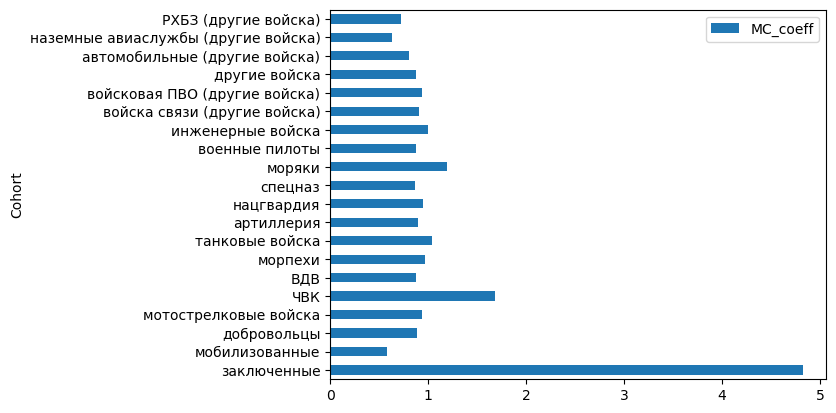

In [29]:
MC_coeffs_to_largest = [(cohort, 1/get_ratio_in_RND_for_cohort(bmz_latest, cohort_name_in_techfield_1=cohort)) for cohort in top_largest_military_cohorts.index]

pd.DataFrame(MC_coeffs_to_largest, columns=['Cohort', 'MC_coeff']).set_index('Cohort').plot.barh()

In [30]:
def add_MCs(df):
    '''
    Adds boolean columns marking Military Categories of the record.
    Default category is MC_0
    '''
    return (df
            .assign(MC_1_convicts =  lambda df_: 
                                                  (df_.techfield_1.str.contains(r'заключенные', na=False))
                                                &(~df_.techfield_2.str.contains(r'\?', na=False))
                                                &(~df_.techfield_2.str.contains(r'по месту захоронения', na=False)),
                    MC_2_volunteers = lambda df_: 
                                                  (df_.techfield_1.str.contains(r'добровольцы', na=False)),
                    MC_0 = lambda df_: ~(df_['MC_1_convicts']|df_['MC_2_volunteers'])
                   )
           )



In [31]:
def get_MC_coeffs(df,
                  MC_list=['MC_1_convicts', 'MC_2_volunteers']):
    d={}
    for i, MC in enumerate(MC_list):
        result =(df
                .pipe(add_Age_cohort)
                .loc[lambda df_: df_.DeathDate <= last_valid_date_in_analysis]
                .pipe(add_MCs)
                .pipe(get_matches, by_marker=MC)
                .pipe(add_IsoYearWeek)
                .groupby(['Year', 'Week'])
                .agg({'InRND':['count', 'sum'],
                      'InRND_matched':['count', 'sum']})
                .sum()
                )

        ratio = (  (result.loc[('InRND', 'sum')]/result.loc[('InRND', 'count')])
                  /(result.loc[('InRND_matched', 'sum')]/result.loc[('InRND_matched', 'count')]))
        MC_coeff = 1/ratio
        MC_coeff_BE = get_binomial_error(result.loc[('InRND', 'count')], result.loc[('InRND', 'sum')])        
        d.update({i:{'MC_name':MC, 'MC_coeff':MC_coeff, 'MC_coeff_BE':MC_coeff_BE}})
        
    return pd.DataFrame(d).transpose()

In [32]:
MC_coeffs_df = get_MC_coeffs(bmz_latest, MC_list=['MC_1_convicts', 'MC_2_volunteers'])
MC_coeffs_df

MC_name  MC_coeff MC_coeff_BE
0    MC_1_convicts  2.770427    0.010224
1  MC_2_volunteers  0.937926    0.024277

In [33]:
def plot_MC_estimation(df,
                       MC):
    return (df
            .pipe(add_Age_cohort)
            .loc[lambda df_: df_.DeathDate <= last_valid_date_in_analysis]
            .pipe(add_MCs)
            .pipe(get_matches, by_marker=MC)
            .set_index('DeathDate')
            .resample('W')
            .agg({'InRND':['count', 'sum'],
                  'InRND_matched':['count', 'sum']})
            .cumsum()
            .loc[lambda df_: df_[('InRND', 'sum')]>10]
            .assign(ratio = lambda df_: df_[('InRND_matched', 'sum')]/df_[('InRND', 'sum')])
            .assign(ratio_BE = lambda df_: get_binomial_error (df_[('InRND', 'count')], df_[('InRND', 'sum')]) )
            #  TODO - here we should plot binomial errors along with the ratio
            ['ratio']
            .plot(figsize=(5, 5), 
                  ylim=(0,5),
                  grid=True
                 )
    
)

<Axes: xlabel='DeathDate'>

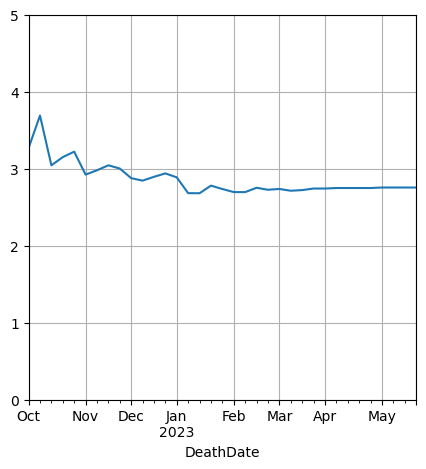

In [34]:
plot_MC_estimation(bmz_latest, MC='MC_1_convicts')

Specific apply function that summarizes the impact of all shares and coeffs of all military cohorts.

This multiplier, basically:
$(1 - \sum_{i=1}^{n}S_i + \sum_{i=1}^{n} S_i \times MC_i)$

In [35]:
def get_MC_eff (df):
    '''
    Basically, this calculates the multiplier
    $(1 - \sum_{i=1}^{n}S_i + \sum_{i=1}^{n} S_i \times MC_i)$

    '''
    return ( 1 - df['MC_share'].sum() + (df['MC_share'] * df['MC_coeff']).sum())

In [36]:
def get_MC_shares_age_time_cartesian (df,
                                      MC_names=['MC_1_convicts', 'MC_2_volunteers'],
                                      main_age_cohorts=main_age_cohorts):
    '''
    Takes BMZ, filters out records without clear DeathDate and Age cohort,
    takes only main_age_cohorts (!)
    than calculates shares of military cohorts: by time and by age.
    Since number of records is too limited, we assume that time/age distribution of shares is constant.
    Hence, final shares are calculated as a cartesian product of distributions by time and by age.
    '''
    df_filtered= (
        df
        .pipe(add_Age_cohort)
        .loc[lambda df_: df_['Age_cohort'].isin(main_age_cohorts)]
        .dropna(subset='DeathDate')
        .pipe(add_IsoYearWeek)
        .pipe(add_MCs)
    )
    
    shares_by_time = (
        df_filtered
        .groupby(['Year', 'Week'])
        [MC_names]
        .mean()
        .dropna()
        .reset_index()
        .melt(value_vars=MC_names,
              id_vars=['Year', 'Week'])
        .rename(columns={'variable':'MC_name', 'value':'MC_share_time'})        
                     )
    
    shares_by_age = (
        df_filtered
        .groupby(['Age_cohort'])
        [MC_names]
        .mean()
        .dropna()
        .pipe(lambda df_: df_/df_.mean()) # NB! Hard to grasp, but that's the whole point of destribution of shares
        # .plot()
        .reset_index()
        .melt(value_vars=MC_names,
              id_vars='Age_cohort')
        .rename(columns={'variable':'MC_name', 'value':'MC_share_age'})
                     )
    # return shares_by_age
    return (
        pd
        .merge(shares_by_time,
               shares_by_age,
               on='MC_name',
               how='outer')
        .assign(MC_share=lambda df_: df_['MC_share_time']*df_['MC_share_age'])
        .drop(columns=['MC_share_time','MC_share_age'])
    )

In [37]:
get_MC_shares_age_time_cartesian(bmz_latest)

Year  Week          MC_name Age_cohort  MC_share
0     2022     5    MC_1_convicts         15       0.0
1     2022     5    MC_1_convicts         20       0.0
2     2022     5    MC_1_convicts         25       0.0
3     2022     5    MC_1_convicts         30       0.0
4     2022     5    MC_1_convicts         35       0.0
...    ...   ...              ...        ...       ...
1017  2023    48  MC_2_volunteers         25       0.0
1018  2023    48  MC_2_volunteers         30       0.0
1019  2023    48  MC_2_volunteers         35       0.0
1020  2023    48  MC_2_volunteers         40       0.0
1021  2023    48  MC_2_volunteers         45       0.0

[1022 rows x 5 columns]

In [38]:
MC_eff_df = (get_MC_shares_age_time_cartesian(bmz_latest)
            .merge(MC_coeffs_df, on='MC_name')
            .groupby(['Year', 'Week', 'Age_cohort'])
            .apply(get_MC_eff)
            .reset_index()
            .rename(columns={0:'MC_eff'})
            )

<Axes: xlabel='Age_cohort', ylabel='Year-Week'>

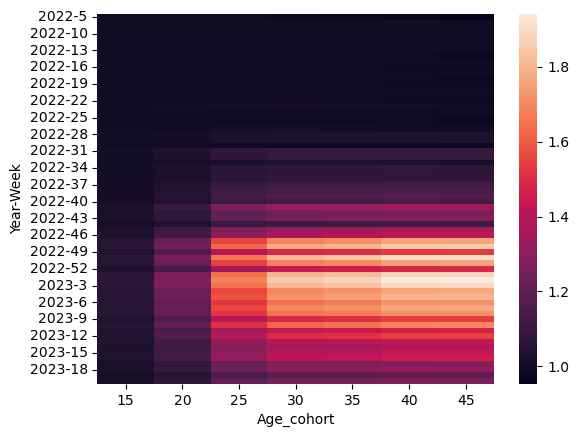

In [39]:
(
    MC_eff_df
    .pipe(exclude_nonexistent_weeks_using_isocalendar, start_date='2014-01-01', end_date=last_valid_date_in_analysis)
    .pivot(columns='Age_cohort', values='MC_eff', index=['Year', 'Week'])
    .pipe(sns.heatmap)
)

## 3.Bottom line

In [62]:
def replace_week_index_with_date_index(df):
    if df.index.names==['Year', 'Week']:
        df = df.reset_index()
    else:
        pass
    return (
        pd
        .DataFrame({'Date':pd.date_range('1900-01-01', '2100-01-01', freq='D')})
        .assign(Year = lambda df_: df_.Date.dt.isocalendar()['year'],
                Week = lambda df_: df_.Date.dt.isocalendar()['week'])
        .merge(df,
               on=['Year','Week'],
               how='inner')
        .groupby(['Year', 'Week'], as_index=False)
        .first()
        .set_index('Date')
        .drop(columns=['Year','Week'])
    )

### 3.1 Finals for 2022

In [63]:
final_2022 = (
    main_df
    .loc[lambda df_: df_['Year']==2022]
    .loc[lambda df_: df_['Sex']=='m']
    .loc[lambda df_: df_['IsWar']==True]
            # .loc[lambda df_: (df_['Delay']=='late')]
    .assign(EC_4 = lambda df_: df_['Cases_adj']-df_['baseline_4'])
    .merge(CTD_Coefs_Apr_auto_f5[['Sex', 'Age', 'CTD']],
          on=['Sex','Age'], 
          how='left')
    .merge(MC_eff_df.rename(columns={'Age_cohort':'Age'}),
           on= ['Year', 'Week', 'Age'],
          )
    .assign(ED_4 = lambda df_: (df_['EC_4']*df_['CTD']*df_['MC_eff']).mask(~df_['IsWar']))
    # .assign(ED_4 = lambda df_: (df_['EC_4']*df_['CTD']).mask(~df_['IsWar']))
    
    .groupby(['Year', 'Week', 'Age'])
    ['ED_4']
    .sum()
    .astype('float')
    .unstack(level=2)
)

<Axes: xlabel='Age', ylabel='Year-Week'>

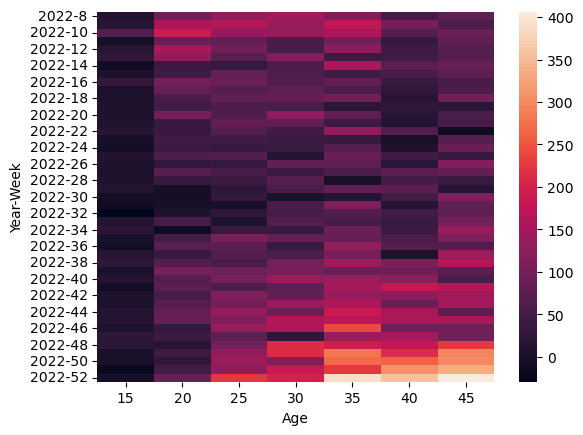

In [64]:
final_2022.pipe(sns.heatmap)

<Axes: xlabel='Year,Week'>

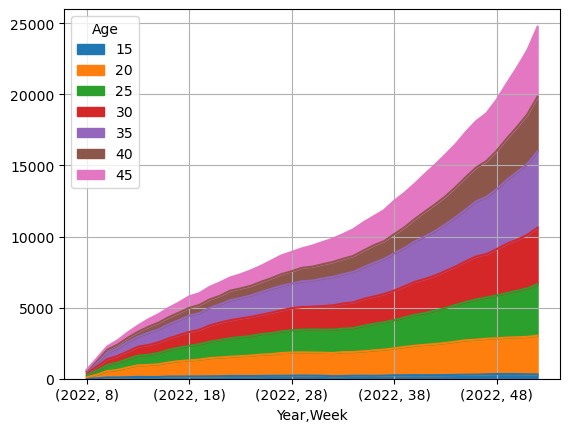

In [65]:
final_2022.cumsum().plot.area(grid=True)

<Axes: xlabel='Year,Week'>

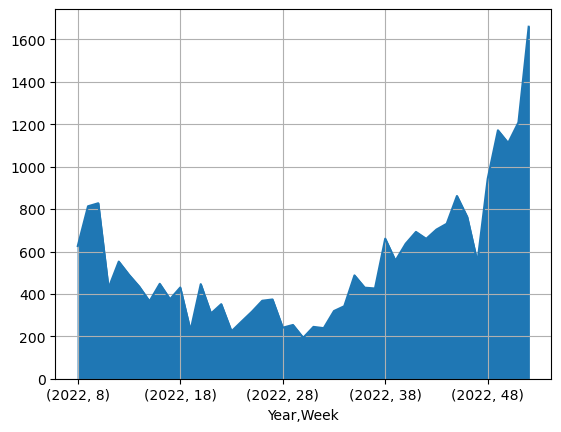

In [66]:
final_2022.sum(axis=1).plot.area(grid=True)

<Axes: xlabel='Age'>

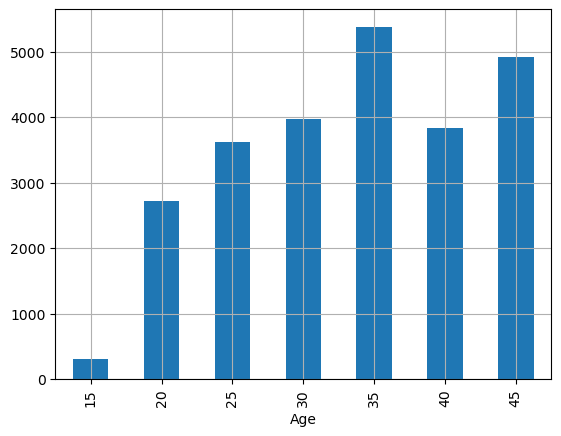

In [67]:
final_2022.sum().plot.bar(grid=True)

In [68]:
print(f'Final figure for 2022 is {final_2022.sum().sum()}')

Final figure for 2022 is 24759.431397287364


### 3.1 Finals for 2023

In [69]:
# name for final_20230605 stands for the latest download date, not date of analisys
final_20230626 = (
    main_df
    # .loc[lambda df_: df_['Year']==2022]
    .loc[lambda df_: df_['Sex']=='m']
    .loc[lambda df_: df_['IsWar']==True]
            # .loc[lambda df_: (df_['Delay']=='late')]
    .assign(EC_4 = lambda df_: df_['Cases_adj']-df_['baseline_4'])
    .merge(CTD_Coefs_Apr_auto_f5[['Sex', 'Age', 'CTD']],
          on=['Sex','Age'], 
          how='left')
    .merge(MC_eff_df.rename(columns={'Age_cohort':'Age'}),
           on= ['Year', 'Week', 'Age'],
          )
    .assign(ED_4 = lambda df_: (df_['EC_4']*df_['CTD']*df_['MC_eff']).mask(~df_['IsWar']))
    # .assign(ED_4 = lambda df_: (df_['EC_4']*df_['CTD']).mask(~df_['IsWar']))

    .groupby(['Year', 'Week', 'Age'])
    ['ED_4']
    .sum()
    .astype('float')
    .unstack(level=2)
)

<Axes: xlabel='Age', ylabel='Year-Week'>

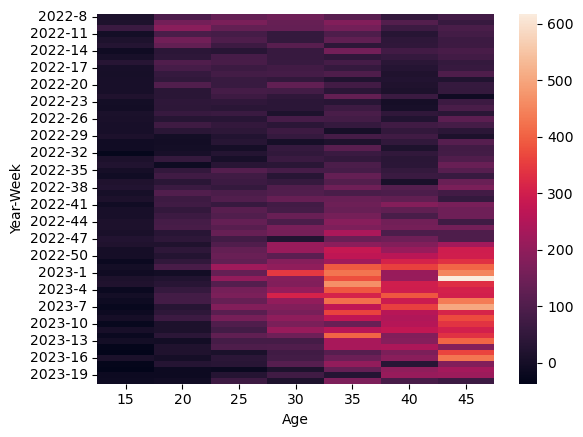

In [70]:
final_20230626.pipe(sns.heatmap)

<Axes: xlabel='Year,Week'>

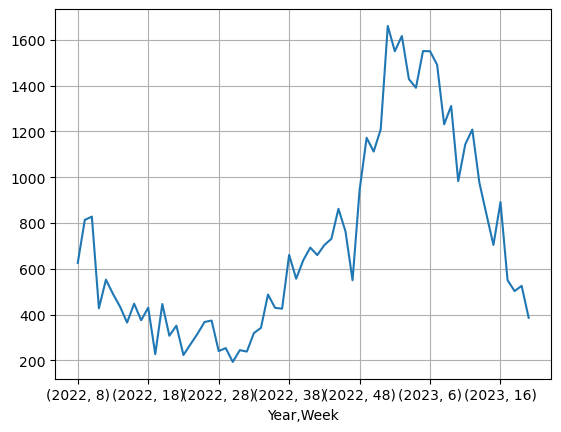

In [71]:
final_20230626.sum(axis=1).plot(grid=True)

<Axes: xlabel='Age'>

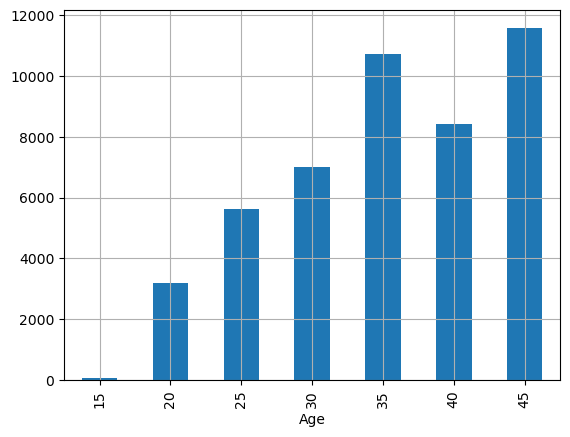

In [72]:
final_20230626.sum().plot.bar(grid=True)

In [73]:
final_20230626.tail()

Age               15         20         25          30          35  \
Year Week                                                            
2023 16    10.111700  -0.852334  38.606123   79.980834  143.391520   
     17   -29.846582  27.064021  32.930255  110.139370  202.568532   
     18   -37.516364 -16.308305 -18.410397   14.355054  132.744083   
     19   -16.278562 -14.915818  27.432946   73.046490   28.440253   
     20   -13.128194  -7.766211  69.851052   13.967108  171.759815   

Age                40          45  
Year Week                          
2023 16    189.907548  430.164575  
     17     32.841022  174.802984  
     18    198.669182  229.086173  
     19    210.809847  216.985976  
     20     85.642636   65.635917

Consult about week numbers [here](https://www.calendar.best/pdf/2023/week-numbers/week-number-2023-iso.pdf)
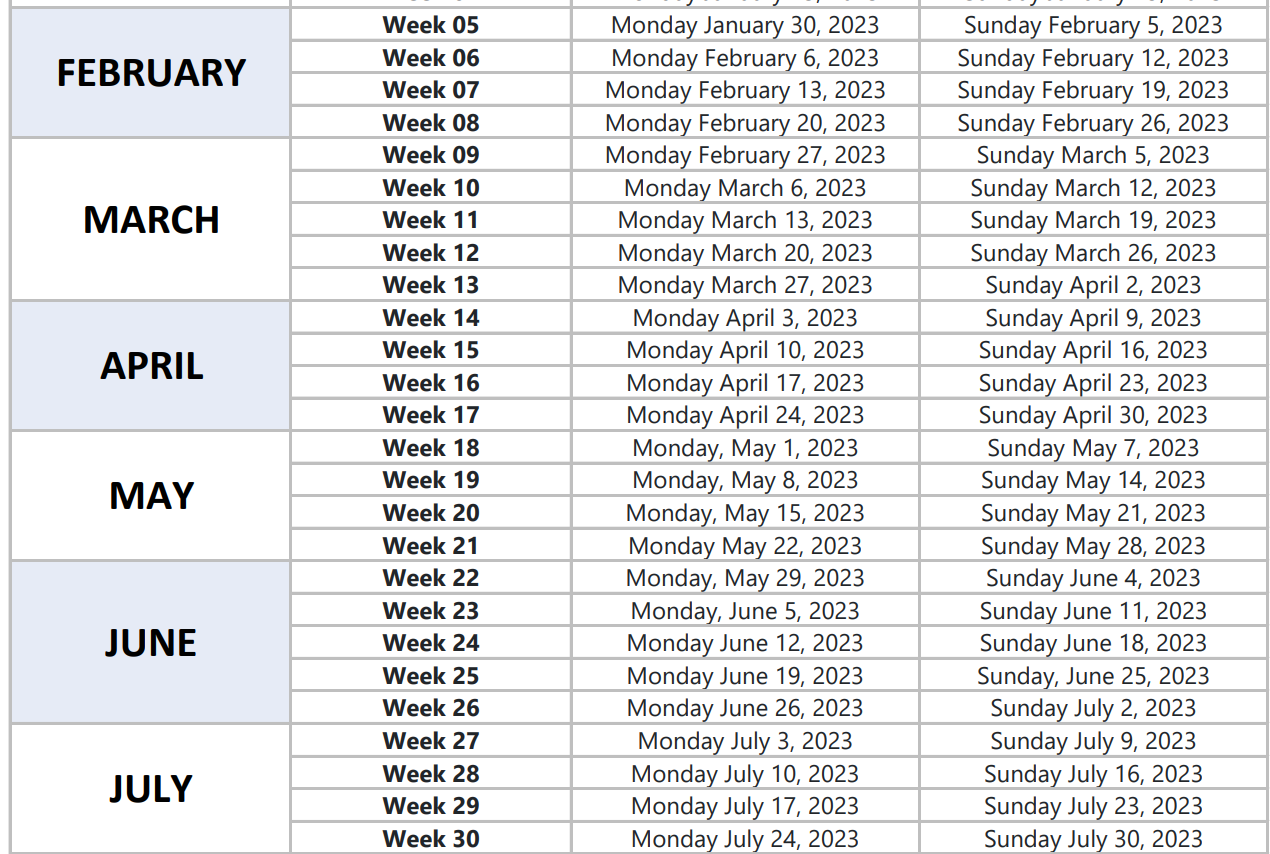

In [74]:
print(f'Final figure for 2023 is {final_20230626.sum().sum()}')

Final figure for 2023 is 46583.60145162056


In [75]:
import datetime
datetime.datetime.now()

datetime.datetime(2023, 7, 6, 19, 20, 46, 880925)

In [76]:
last_valid_date_in_analysis

Timestamp('2023-05-27 00:00:00')

### 3.1 A Finals for 2023 + errors

In [140]:
# name for final_20230605 stands for the latest download date, not date of analisys
final_20230626 = (
    main_df
    # .loc[lambda df_: df_['Year']==2022]
    .loc[lambda df_: df_['Sex']=='m']
    .loc[lambda df_: df_['IsWar']==True]
            # .loc[lambda df_: (df_['Delay']=='late')]
    .assign(EC_4 = lambda df_: df_['Cases_adj']-df_['baseline_4'])
    .merge(CTD_Coefs_Apr_auto_f5, #[['Sex', 'Age', 'CTD']],
          on=['Sex','Age'], 
          how='left')
    .merge(MC_eff_df.rename(columns={'Age_cohort':'Age'}),
           on= ['Year', 'Week', 'Age'],
          )
    .assign(ED_4_max = lambda df_: (df_['EC_4']
                                    *(1/(df_['Ratio']-df_['Ratio_BE']))
                                    *df_['MC_eff']).mask(~df_['IsWar']))
    .assign(ED_4_min = lambda df_: (df_['EC_4']
                                    *(1/(df_['Ratio']+df_['Ratio_BE']))
                                    *df_['MC_eff']).mask(~df_['IsWar']))
    .assign(ED_4 = lambda df_: (df_['EC_4']*df_['CTD']*df_['MC_eff']).mask(~df_['IsWar']))
    .groupby(['Year', 'Week', 'Age'])
    [['ED_4', 'ED_4_max', 'ED_4_min']]
    .sum()
    .astype('float')
    # .unstack(level=2)
)
final_20230626

ED_4    ED_4_max    ED_4_min
Year Week Age                                    
2022 8    15    12.498551   20.743687    8.943655
          20    95.188132  105.729763   86.557995
          25   131.657333  149.383748  117.691620
          30   147.363057  166.677592  132.059996
          35   112.009304  129.874106   98.464977
...                   ...         ...         ...
2023 20   25    69.851052   79.255835   62.441516
          30    13.967108   15.797745   12.516680
          35   171.759815  199.154460  150.990370
          40    85.642636   99.112128   75.396179
          45    65.635917   87.870127   52.381555

[455 rows x 3 columns]

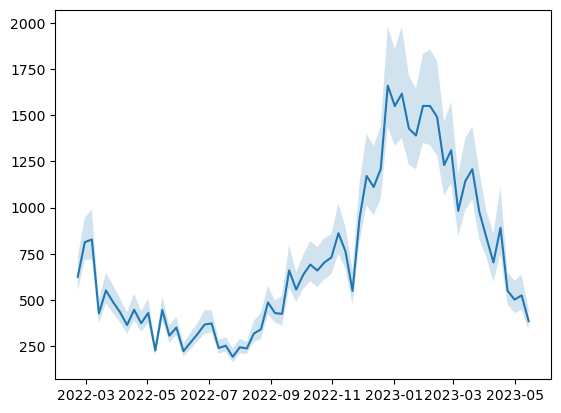

In [141]:
data = (
    final_20230626
    .reset_index()
    .groupby(['Year', 'Week'])
    [[ 'ED_4_max', 'ED_4', 'ED_4_min']]
    .sum()
    .pipe(replace_week_index_with_date_index)
)

data
fig, ax = plt.subplots()
ax.plot(data.index, data['ED_4'], '-')
ax.fill_between(data.index, data['ED_4_min'], data['ED_4_max'], alpha=0.2)


In [138]:
final_20230626.sum()

ED_4        46583.601452
ED_4_max    55603.737762
ED_4_min    40313.810086
dtype: float64

In [139]:
46583.601452-55603.737762

-9020.136309999994

In [510]:
(
    main_df
    .loc[lambda df_: df_['IsWar']==True]
    .loc[lambda df_: df_['Sex']=='m']
    .loc[lambda df_: df_['Age']=='20']
    .loc[lambda df_: (df_['Year']==2022)&(df_['Week']==9)]
    .assign(EC_4 = lambda df_: df_['Cases_adj']-df_['baseline_4'])
    .merge(CTD_Coefs_Apr_auto_f5[['Sex', 'Age', 'CTD']],
           on=['Sex','Age'], 
           how='left')
    .merge(MC_eff_df.rename(columns={'Age_cohort':'Age'}),
           on= ['Year', 'Week', 'Age'],
          )
    .assign(ED_4 = lambda df_: (df_['EC_4']*df_['CTD']*df_['MC_eff']).mask(~df_['IsWar']).astype('float'))
    .groupby(['Year', 'Week', 'Age'])
    [['Cases', 'Cases_adj', 'baseline_4', 'EC_4', 'ED_4']]
    .sum()
)

Cases   Cases_adj  baseline_4       EC_4        ED_4
Year Week Age                                                      
2022 9    20     117  123.122834   33.776627  89.346208  156.607925

In [511]:
CTD_Coefs_Apr_auto_f5

Age Sex     Ratio  Ratio_BE       CTD
0         15   m  0.424242  0.168627  2.357143
1         20   m  0.570447  0.056876  1.753012
2         25   m  0.589474  0.069949  1.696429
3         30   m  0.671429  0.077805  1.489362
4         35   m      0.67  0.092162  1.492537
5         40   m    0.8125  0.110420  1.230769
6         45   m       0.8  0.202428      1.25
7  NoAgeData   m      0.62  0.040566  1.612903

In [509]:
(123.122834-33.776627)*(1/0.570447)

156.62490468001405

### 3.3 Let's look specifically into late cases (`CaseDate-DeathDate >= 128`)

In [77]:
main_df_late_128 = (
    pd
    .read_parquet(parsed_table_path)
    .pipe(add_ToBeAggregated)
    .loc[lambda df_: df_['ToBeAggregated']==True]
    
#     here we drop all records where CaseDelayDays < 128 days
    .assign(CaseDelayDays = lambda df_: (df_['CaseDate']- df_['DeathActDate']).dt.days)
    .loc[lambda df_: df_['CaseDelayDays']>=128]

#     the following is exactly the same as in the main analisys
    .groupby(['Year', 'Week', 'Sex', 'Age', 'Delay'])
    .agg({'DeathDate':'count', 'CaseWeight':'sum'})
    .rename(columns={'DeathDate':'Cases', 'CaseWeight':'Cases_adj'})
    .reset_index()
    .pipe(redistribute_unknows)
    .pipe(exclude_nonexistent_weeks_using_isocalendar, start_date='2014-01-01', end_date=(last_valid_date_in_analysis-pd.Timedelta(days=128)))
    .assign(IsWar = lambda df_: year_week_is_in_datespan(df_, start_date='2022-02-24'))
    .pipe(add_Split)
    .pipe(add_deaths)
    .pipe(add_baseline_1)
    .pipe(add_baseline_2)
    .pipe(add_baseline_3)
    .pipe(add_baseline_4)
    .pipe(add_baseline_5, smoothing_window=1)
)
main_df_late_128


    all_aggregated_cases:	3425040,

    all_aggregated_cases_whithout_unknowns:	3373487.

    share of unknowns:	1.51%
          


Year  Week Sex Age  Delay  Cases  Cases_adj  IsWar    Split  \
0      2014     1   f   0  early      4   4.000000  False    train   
1      2014     1   f   0   late      2   2.000000  False    train   
2      2014     1   f  10  early      1   1.000000  False    train   
3      2014     1   f  10   late      0   0.000000  False    train   
4      2014     1   f  15  early      2   2.000000  False    train   
...     ...   ...  ..  ..    ...    ...        ...    ...      ...   
37755  2023     2   m  85   late     12  16.409047   True  predict   
37756  2023     2   m  90  early     40  50.920234   True  predict   
37757  2023     2   m  90   late      5   6.772799   True  predict   
37758  2023     2   m  95  early      7   9.030093   True  predict   
37759  2023     2   m  95   late      0   0.000000   True  predict   

             Deaths  baseline_1  baseline_2  baseline_2_std  baseline_3  \
0       6202.052618         NaN    4.857143        4.180453    9.789567   
1       6202.052618         NaN    1.571429        0.975900    2.010449   
2        742.724829         NaN    1.000000        0.577350    0.976030   
3        742.724829         NaN    0.571429        0.534522    0.580872   
4       1619.580558         NaN    3.000000        0.577350    2.529829   
...             ...         ...         ...             ...         ...   
37755  75905.952407   30.338491   21.437691        5.710561   37.571691   
37756  35109.908944  113.942769   72.000000       30.811253  139.027713   
37757  35109.908944   13.599499    8.147186        4.146329   19.978534   
37758  16233.429078   27.177794   14.285714        3.592320   26.929210   
37759  16233.429078    4.184373    1.428571        0.975900    3.489690   

       baseline_4  baseline_5  
0             NaN         NaN  
1             NaN         NaN  
2             NaN         NaN  
3             NaN         NaN  
4             NaN         NaN  
...           ...         ...  
37755   23.455825   12.806000  
37756   77.424041   73.513530  
37757   11.005473    4.498393  
37758   19.937943   16.793853  
37759    5.582972    4.295372  

[37760 rows x 16 columns]

<Axes: xlabel='Year,Week'>

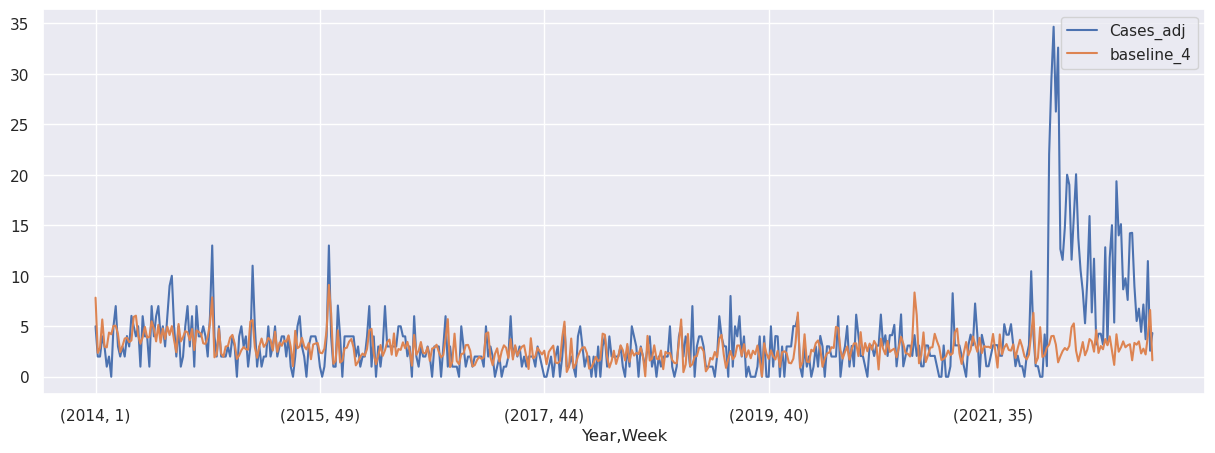

In [78]:
(
    main_df_late_128
    .loc[lambda df_: (df_['Age']=='20')&(df_['Delay']=='late')&(df_['Sex']=='m')]
    .reset_index(drop=True)
    .set_index(['Year', 'Week'])
    .assign(EC_4       = lambda df_: df_['Cases_adj']-df_['baseline_4'])
    .pipe(exclude_nonexistent_weeks_using_isocalendar, start_date='2014-01-01', end_date=last_valid_date_in_analysis)
    .set_index(['Year', 'Week'])
    [[
        # 'Cases',
        'Cases_adj',
        'baseline_4',
        # 'EC_4',
    ]]
    # .tail(200)
    .plot(figsize=(15,5), grid=True)
)

In [79]:
final_late_128 = (
    main_df_late_128
    .loc[lambda df_: df_['Sex']=='m']
    .loc[lambda df_: df_['IsWar']==True]
    .assign(EC_4 = lambda df_: df_['Cases_adj']-df_['baseline_4'])
    .merge(CTD_Coefs_Apr_auto_f5[['Sex', 'Age', 'CTD']],
          on=['Sex','Age'], 
          how='left')
    .merge(MC_eff_df.rename(columns={'Age_cohort':'Age'}),
           on= ['Year', 'Week', 'Age'],
          )
    .assign(ED_4 = lambda df_: (df_['EC_4']*df_['CTD']*df_['MC_eff']).mask(~df_['IsWar']))
    .groupby(['Year', 'Week', 'Age'])
    ['ED_4']
    # ['baseline_4']
    .sum()
    .astype('float')
    .unstack(level=2)
)

<Axes: xlabel='Age', ylabel='Year-Week'>

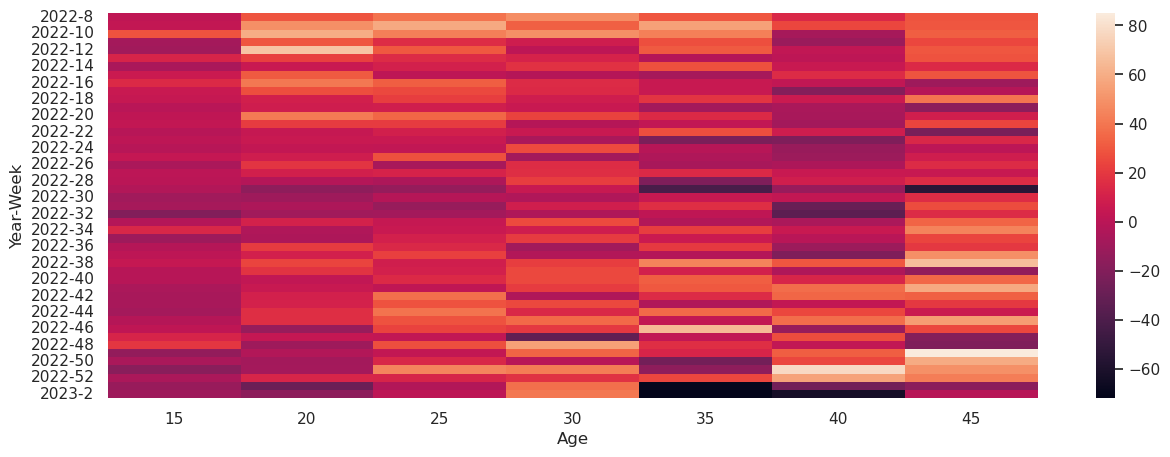

In [80]:
final_late_128.pipe(sns.heatmap)

<Axes: xlabel='Year,Week'>

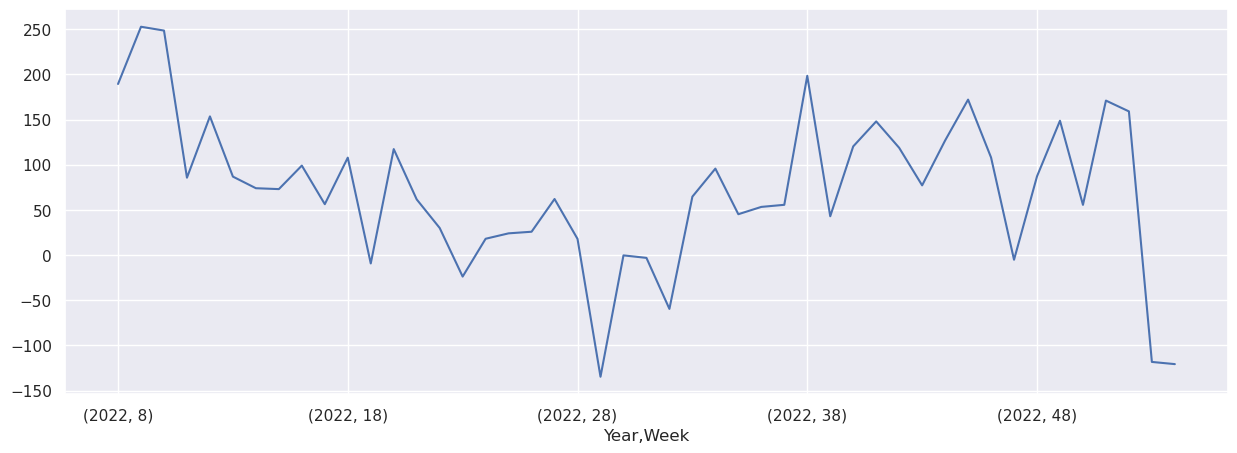

In [81]:
final_late_128.sum(axis=1).plot(grid=True)

<Axes: xlabel='Age'>

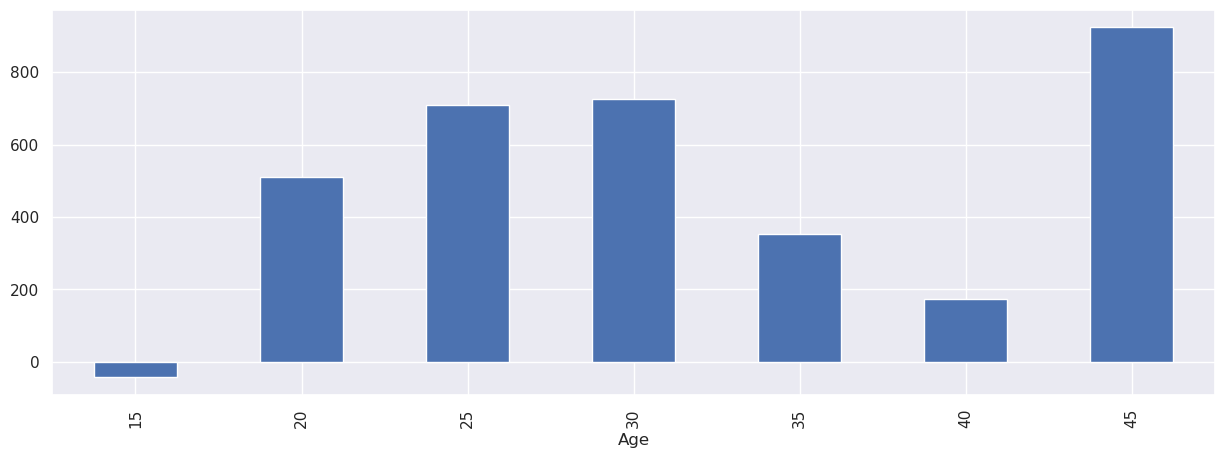

In [82]:
final_late_128.sum().plot.bar(grid=True)

In [83]:
print(f'Final figure for 2023 for LATE CASES (>=128) {final_late_128.sum().sum()}')

Final figure for 2023 for LATE CASES (>=128) 3355.522465111224


### Let's look specifically into late cases (`CaseDate-DeathDate >= 82`)

In [84]:
main_df_late_82 = (
    pd
    .read_parquet(parsed_table_path)
    .pipe(add_ToBeAggregated)
    .loc[lambda df_: df_['ToBeAggregated']==True]
    
#     here we drop all records where CaseDelayDays < 128 days
    .assign(CaseDelayDays = lambda df_: (df_['CaseDate']- df_['DeathActDate']).dt.days)
    .loc[lambda df_: df_['CaseDelayDays']>=82]

#     the following is exactly the same as in the main analisys
    .groupby(['Year', 'Week', 'Sex', 'Age', 'Delay'])
    .agg({'DeathDate':'count', 'CaseWeight':'sum'})
    .rename(columns={'DeathDate':'Cases', 'CaseWeight':'Cases_adj'})
    .reset_index()
    .pipe(redistribute_unknows)
    .pipe(exclude_nonexistent_weeks_using_isocalendar, start_date='2014-01-01', end_date=(last_valid_date_in_analysis-pd.Timedelta(days=128)))
    .assign(IsWar = lambda df_: year_week_is_in_datespan(df_, start_date='2022-02-24'))
    .pipe(add_Split)
    .pipe(add_deaths)
    .pipe(add_baseline_1)
    .pipe(add_baseline_2)
    .pipe(add_baseline_3)
    .pipe(add_baseline_4)
    .pipe(add_baseline_5, smoothing_window=1)
)
main_df_late_82


    all_aggregated_cases:	5261550,

    all_aggregated_cases_whithout_unknowns:	5189672.

    share of unknowns:	1.37%
          


Year  Week Sex Age  Delay  Cases   Cases_adj  IsWar    Split  \
0      2014     1   f   0  early      6    6.000000  False    train   
1      2014     1   f   0   late      2    2.000000  False    train   
2      2014     1   f  10  early      1    1.000000  False    train   
3      2014     1   f  10   late      0    0.000000  False    train   
4      2014     1   f  15  early      2    2.000000  False    train   
...     ...   ...  ..  ..    ...    ...         ...    ...      ...   
37755  2023     2   m  85   late     29   40.833176   True  predict   
37756  2023     2   m  90  early     81  103.329643   True  predict   
37757  2023     2   m  90   late     12   16.998637   True  predict   
37758  2023     2   m  95  early     25   31.943549   True  predict   
37759  2023     2   m  95   late      0    0.000000   True  predict   

             Deaths  baseline_1  baseline_2  baseline_2_std  baseline_3  \
0       6202.052618         NaN    6.714286        5.219013   13.535732   
1       6202.052618         NaN    1.857143        1.069045    2.366314   
2        742.724829         NaN    1.285714        0.755929    0.993759   
3        742.724829         NaN    0.714286        0.755929    0.690258   
4       1619.580558         NaN    3.714286        1.253566    3.139808   
...             ...         ...         ...             ...         ...   
37755  75905.952407   51.267499   32.294833        9.962624   58.578928   
37756  35109.908944  191.299852  106.857143       36.186685  211.740958   
37757  35109.908944   23.014687   10.718614        5.828240   29.576296   
37758  16233.429078   42.858488   20.857143        5.367450   41.557668   
37759  16233.429078    4.184373    2.142857        1.573592    5.466845   

       baseline_4  baseline_5  
0             NaN         NaN  
1             NaN         NaN  
2             NaN         NaN  
3             NaN         NaN  
4             NaN         NaN  
...           ...         ...  
37755   41.506512   42.064530  
37756  150.554232  157.906309  
37757   14.771215   11.355333  
37758   44.753757   34.394788  
37759    8.708760   13.780713  

[37760 rows x 16 columns]

<Axes: xlabel='Year,Week'>

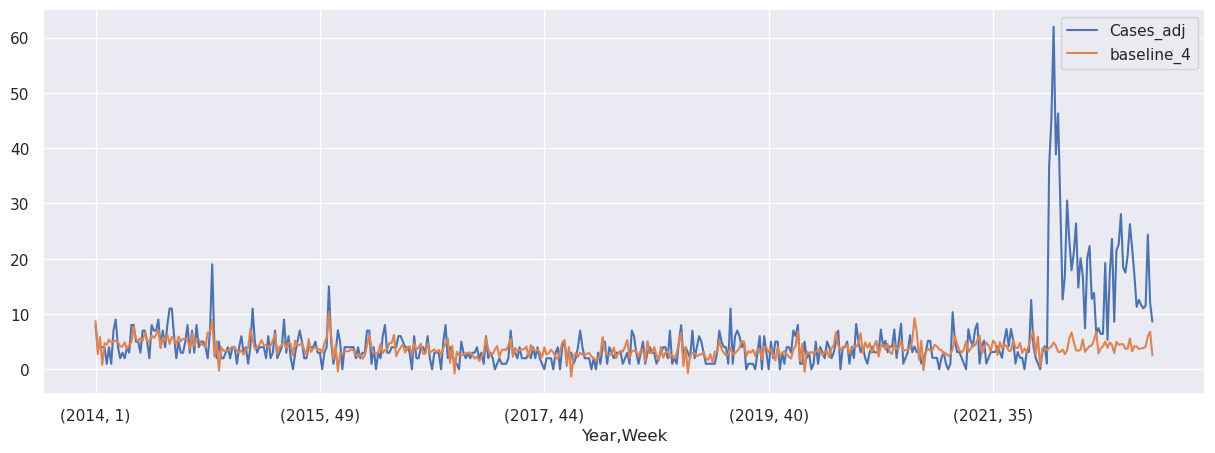

In [85]:
(
    main_df_late_82
    .loc[lambda df_: (df_['Age']=='20')&(df_['Delay']=='late')&(df_['Sex']=='m')]
    .reset_index(drop=True)
    .set_index(['Year', 'Week'])
    .assign(EC_4       = lambda df_: df_['Cases_adj']-df_['baseline_4'])
    .pipe(exclude_nonexistent_weeks_using_isocalendar, start_date='2014-01-01', end_date=last_valid_date_in_analysis)
    .set_index(['Year', 'Week'])
    [[
        # 'Cases',
        'Cases_adj',
        'baseline_4',
        # 'EC_4',
    ]]
    # .tail(200)
    .plot(figsize=(15,5), grid=True)
)

In [86]:
final_late_82 = (
    main_df_late_82
    .loc[lambda df_: df_['Sex']=='m']
    .loc[lambda df_: df_['IsWar']==True]
    .assign(EC_4 = lambda df_: df_['Cases_adj']-df_['baseline_4'])
    .merge(CTD_Coefs_Apr_auto_f5[['Sex', 'Age', 'CTD']],
          on=['Sex','Age'], 
          how='left')
    .merge(MC_eff_df.rename(columns={'Age_cohort':'Age'}),
           on= ['Year', 'Week', 'Age'],
          )
    .assign(ED_4 = lambda df_: (df_['EC_4']*df_['CTD']*df_['MC_eff']).mask(~df_['IsWar']))
    .groupby(['Year', 'Week', 'Age'])
    ['ED_4']
    # ['baseline_4']
    .sum()
    .astype('float')
    .unstack(level=2)
)

<Axes: xlabel='Age', ylabel='Year-Week'>

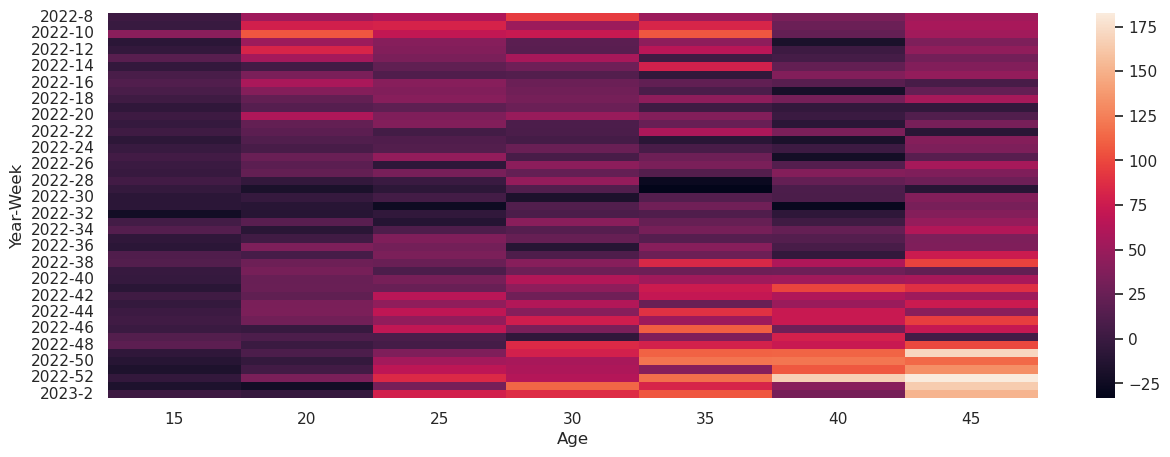

In [87]:
final_late_82.pipe(sns.heatmap)

<Axes: xlabel='Year,Week'>

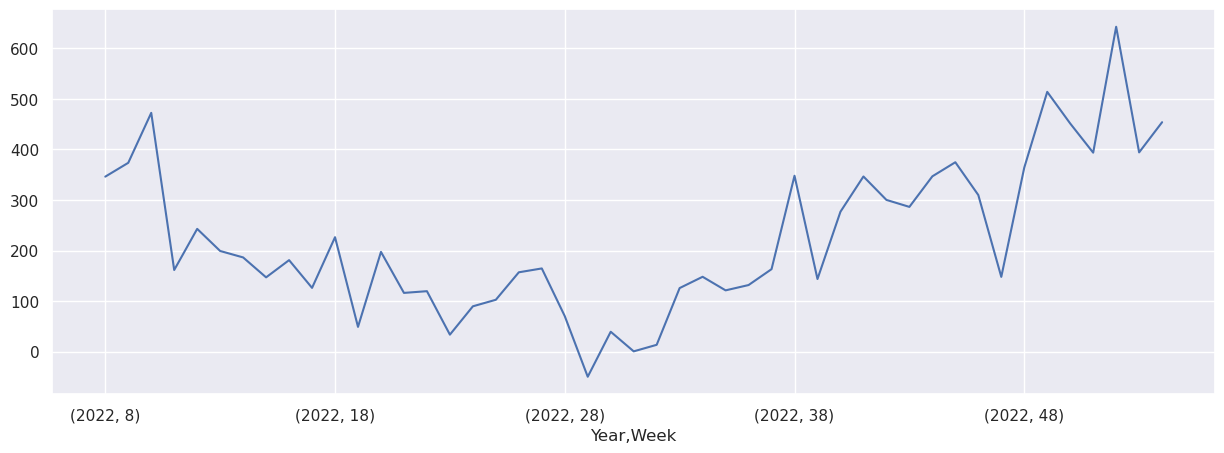

In [88]:
final_late_82.sum(axis=1).plot(grid=True)

<Axes: xlabel='Age'>

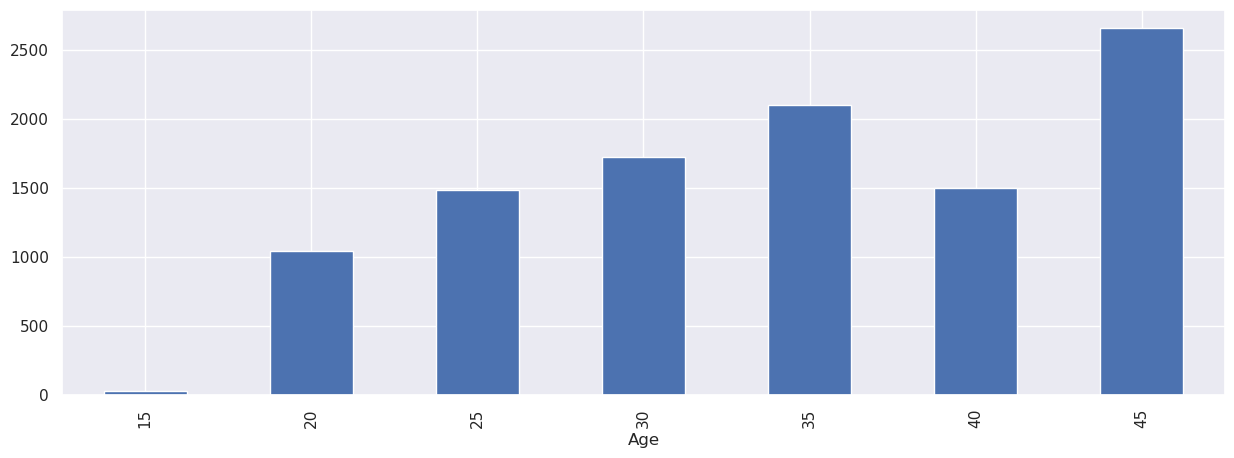

In [89]:
final_late_82.sum().plot.bar(grid=True)

In [90]:
print(f'Final figure for 2023 for LATE CASES (>=82) {final_late_82.sum().sum()}')

Final figure for 2023 for LATE CASES (>=82) 10551.083634534889


In [91]:
3500/20453

0.1711240404830587

In [92]:
final_late_82.sum().sum()*0.27

2848.79258132442

## 4. Pics for text

### 4.1 Main pics

#### Pic 01

In [220]:
data = (
    pd
    .read_parquet(parsed_table_path)
    # .pipe(add_ToBeAggregated)
    # .loc[lambda df_: df_['ToBeAggregated']==True]
    .sample(1_000_000)
    [['DeathDate', 'CaseDate']]
    .loc[lambda df_: df_['DeathDate']>='2014-01-01']
    .loc[lambda df_: df_['CaseDate']>='2014-01-01']

)

In [259]:
# import matplotlib as mpl
# mpl.rcParams.update(mpl.rcParamsDefault)
%matplotlib inline

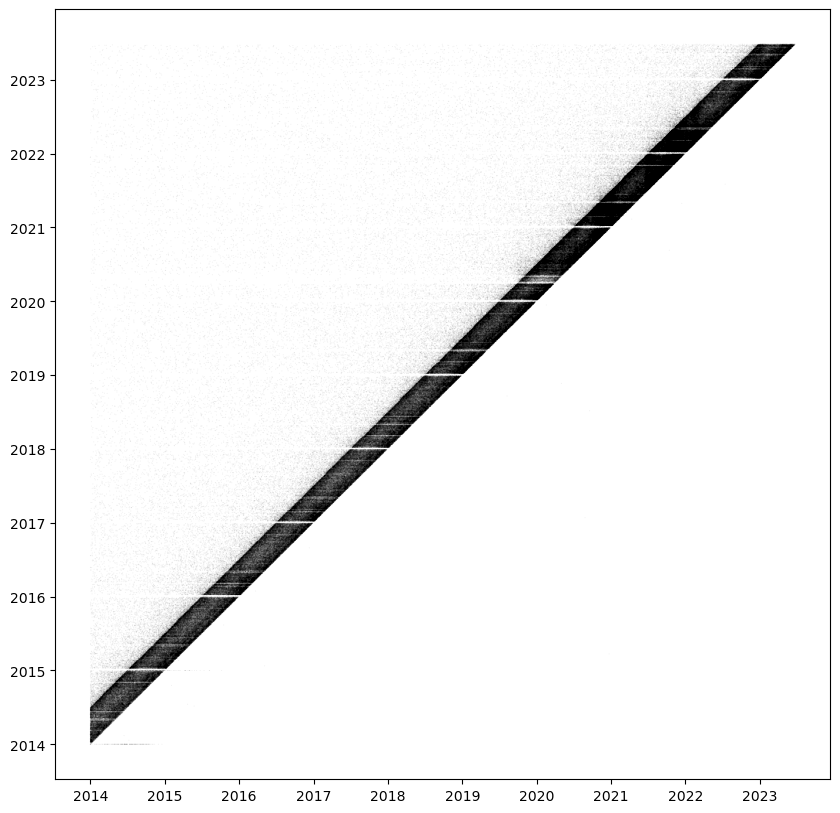

In [260]:
data_to_plot = (
    data
    .loc[lambda df_: df_['DeathDate']>='2014-01-01']
    .loc[lambda df_: df_['CaseDate']>='2014-01-01']
    .loc[lambda df_: df_['DeathDate']<=last_request_date]
    .loc[lambda df_: df_['CaseDate']<=last_request_date]
)


fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1, 1, 1)
ax.set_facecolor('white')
plt.scatter(data_to_plot['DeathDate'],
            data_to_plot['CaseDate'],
            alpha=0.05,
            s=0.7,
            color='black',
            edgecolors='none')
plt.savefig('pics/pic01a_white.png', dpi=300)

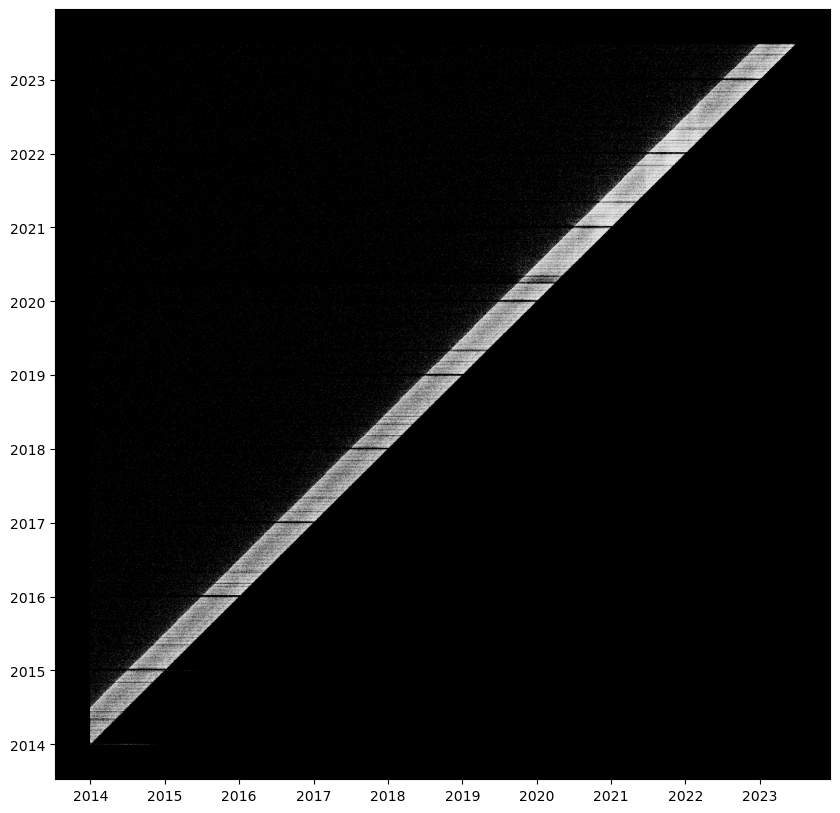

In [261]:
data_to_plot = (
    data
    .loc[lambda df_: df_['DeathDate']>='2014-01-01']
    .loc[lambda df_: df_['CaseDate']>='2014-01-01']
    .loc[lambda df_: df_['DeathDate']<=last_request_date]
    .loc[lambda df_: df_['CaseDate']<=last_request_date]
)


fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1, 1, 1)
ax.set_facecolor('black')
plt.scatter(data_to_plot['DeathDate'],
            data_to_plot['CaseDate'],
            alpha=0.05,
            s=0.7,
            color='white',
            edgecolors='none')
plt.savefig('pics/pic01a_black.png', dpi=300)

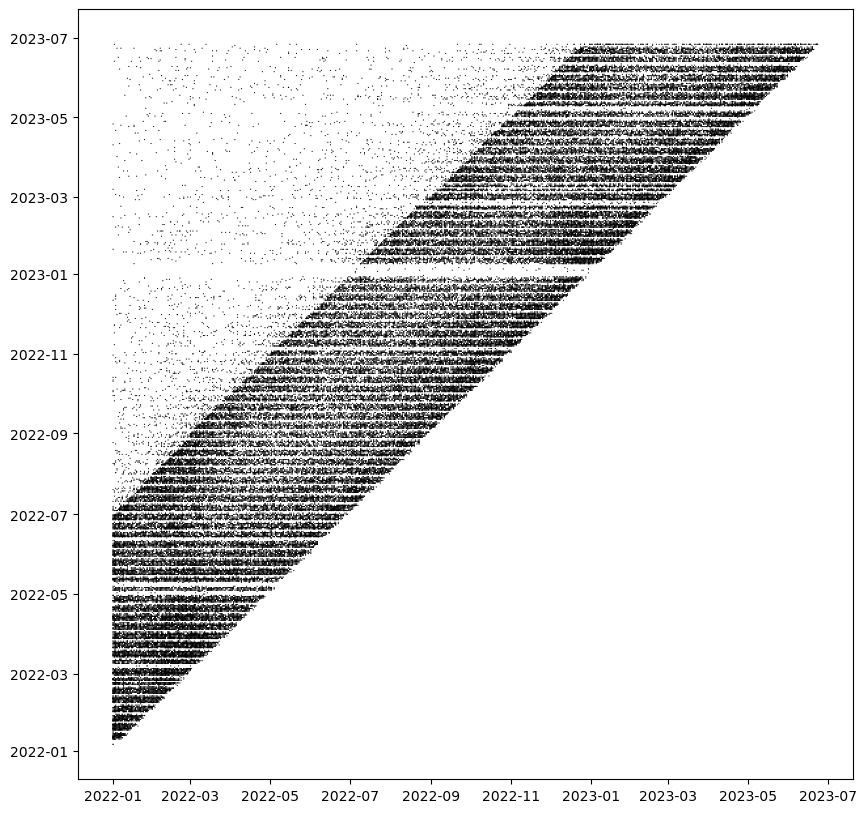

In [262]:
data_to_plot = (
    data
    .loc[lambda df_: df_['DeathDate']>='2022-01-01']
    .loc[lambda df_: df_['CaseDate']>='2022-01-01']
    .loc[lambda df_: df_['DeathDate']<=last_request_date]
    .loc[lambda df_: df_['CaseDate']<=last_request_date]
)


fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1, 1, 1)
ax.set_facecolor('white')
plt.scatter(data_to_plot['DeathDate'],
            data_to_plot['CaseDate'],
            alpha=1,
            s=0.7,
            color='black',
            edgecolors='none')
plt.savefig('pics/pic01b_.png', dpi=300)
plt.savefig('pics/pic01b_.svg')

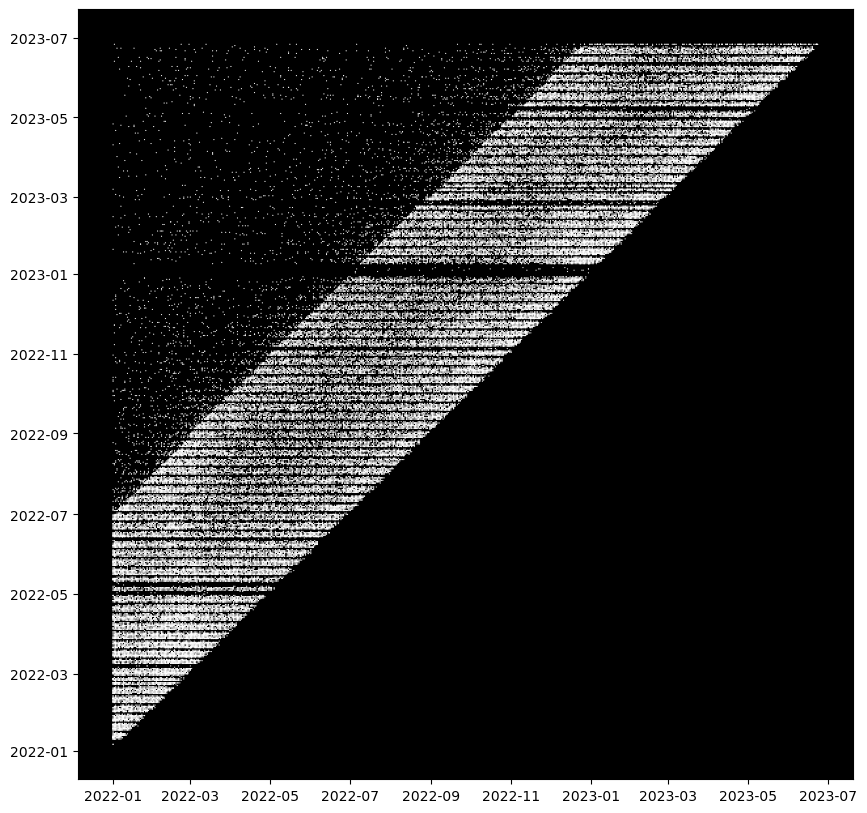

In [263]:
data_to_plot = (
    data
    .loc[lambda df_: df_['DeathDate']>='2022-01-01']
    .loc[lambda df_: df_['CaseDate']>='2022-01-01']
    .loc[lambda df_: df_['DeathDate']<=last_request_date]
    .loc[lambda df_: df_['CaseDate']<=last_request_date]
)


fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1, 1, 1)
ax.set_facecolor('black')
plt.scatter(data_to_plot['DeathDate'],
            data_to_plot['CaseDate'],
            alpha=1,
            s=0.7,
            color='white',
            edgecolors='none')
plt.savefig('pics/pic01b_black.png', dpi=300)


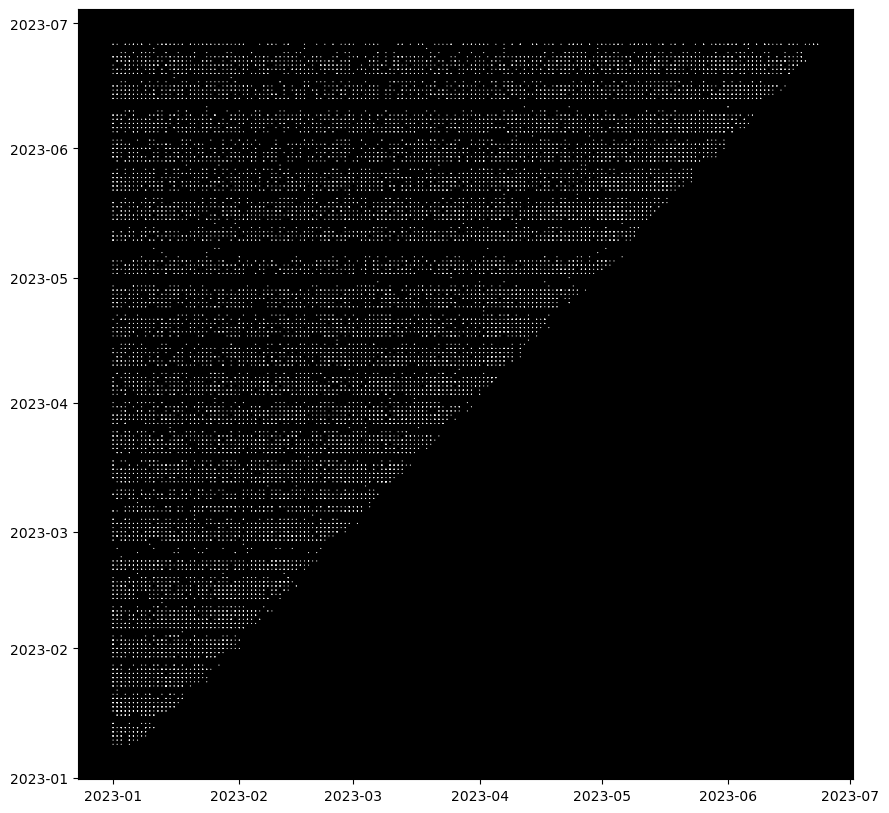

In [264]:
data_to_plot = (
    data
    .loc[lambda df_: df_['DeathDate']>='2023-01-01']
    .loc[lambda df_: df_['CaseDate']>='2023-01-01']
    .loc[lambda df_: df_['DeathDate']<=last_request_date]
    .loc[lambda df_: df_['CaseDate']<=last_request_date]
)


fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1, 1, 1)
ax.set_facecolor('black')
plt.scatter(data_to_plot['DeathDate'],
            data_to_plot['CaseDate'],
            alpha=1,
            s=0.7,
            color='white',
            edgecolors='none')
plt.savefig('pics/pic01c_black.png', dpi=300)


#### Pic 02

STMF

In [82]:
#### Reading STMF
df_STMF = pd.read_csv(STMFIn_redistributed_path, 
                      usecols=['Year', 'Week', 'Sex', 'Age', 'Deaths'], 
                      dtype={ 'Year':int, 
                              'Week':int, 
                              'Age':'category', 
                              'Sex':'category',
                              'Deaths':float})

<Axes: title={'center': 'Отношение чила наследственных дел в выборке РНД\n к общей смертности по STMF в половозрастных когортах в 2020'}, xlabel='Age'>

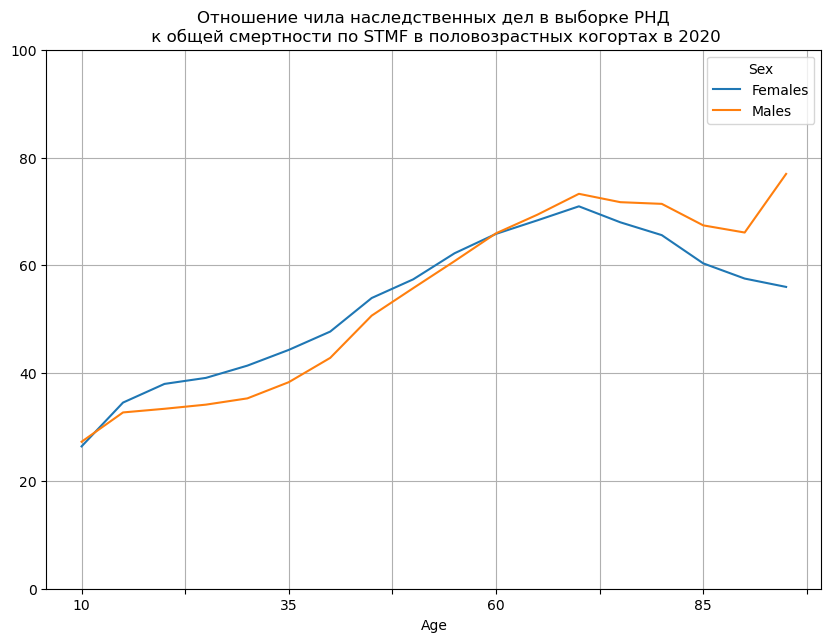

In [96]:
data = (
    main_df
    .groupby(['Year', 'Week', 'Sex', 'Age'], as_index=False)
    ['Cases']
    .sum()
    .merge(df_STMF,
          on=['Year', 'Week', 'Sex', 'Age'],
          how='left')
    .loc[lambda df_: df_['Year']==2020]
    .loc[lambda df_: ~df_['Age'].isin(['0', '5'])]
    .groupby(['Sex', 'Age'])
    [['Cases', 'Deaths']]
    .sum()
    .assign(CaseToDeathRatio = lambda df_: df_['Cases']/df_['Deaths'])
    ['CaseToDeathRatio']
    .unstack(level=0)
    .rename(columns={'f':'Females', 'm':'Males'})
    .pipe(lambda df_: df_*100)
)

(
    data
    .plot(figsize=(10,7),
                  ylim=(0,100),
                  grid=True,
                  title='Отношение чила наследственных дел в выборке РНД\n к общей смертности по STMF в половозрастных когортах в 2020')
)
# data.to_csv('pics/pic02_data.csv')

#### Pic 03

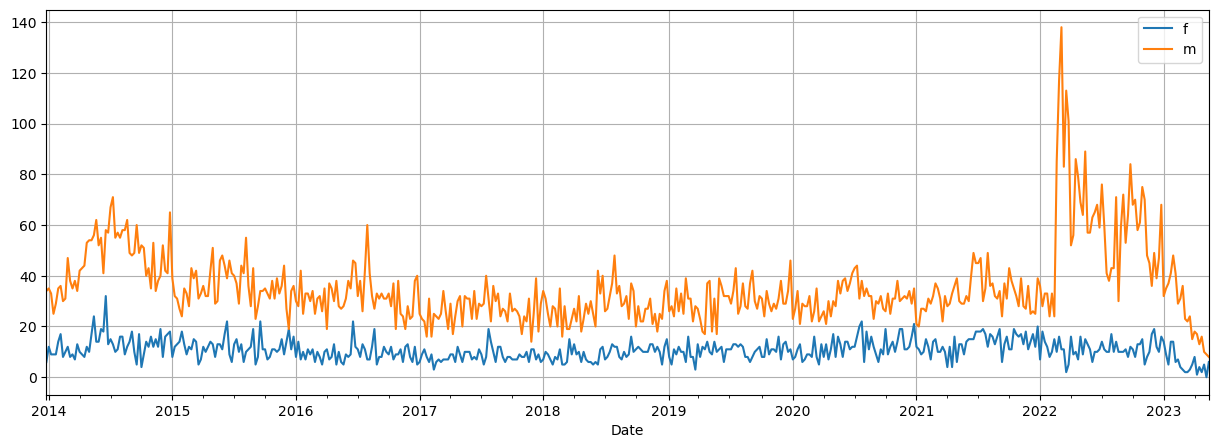

In [101]:
data = (
    main_df
    .assign(EC_4 = lambda df_: df_['Cases_adj']-df_['baseline_4'])
    .merge(CTD_Coefs_Apr_auto_f5[['Sex', 'Age', 'CTD']],
          on=['Sex','Age'], 
          how='left')
    .merge(MC_eff_df.rename(columns={'Age_cohort':'Age'}),
           on= ['Year', 'Week', 'Age'],
           how='left'
          )
    .assign(ED_4 = lambda df_: (df_['EC_4']*df_['CTD']*df_['MC_eff']).mask(~df_['IsWar']).astype('float'))
    .groupby(['Year', 'Week', 'Sex', 'Age'])
    [['Cases', 'Cases_adj', 'baseline_4', 'EC_4', 'ED_4']]
    .sum()
    .astype('float')
    .reset_index(['Sex', 'Age'])
    .loc[lambda df_: df_['Age']=='20']
    .pivot(columns='Sex', values= ['Cases', 'Cases_adj', 'baseline_4', 'EC_4', 'ED_4'])
    ['Cases']
    .pipe(replace_week_index_with_date_index)

)
data.plot(figsize=(15,5), grid=True)
data.to_csv('pics/pic03_data.csv')

#### Pic 04 - P-scores

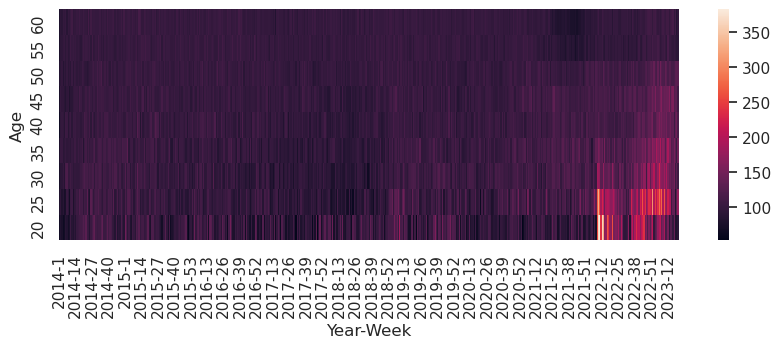

In [322]:
sns.set(rc={'figure.figsize':(10,3)})

data = (
    main_df
    .loc[lambda df_: df_['Age'].isin(main_age_cohorts[1:]+['50', '55', '60'])]
    .assign(EC_4 = lambda df_: df_['Cases_adj']-df_['baseline_4'])
    .merge(CTD_Coefs_Apr_auto_f5[['Sex', 'Age', 'CTD']],
          on=['Sex','Age'], 
          how='left')
    .merge(MC_eff_df.rename(columns={'Age_cohort':'Age'}),
           on= ['Year', 'Week', 'Age'],
           how='left'
          )

    .groupby(['Year', 'Week', 'Sex', 'Age'])
    [['Cases', 'Cases_adj', 'baseline_4', 'EC_4']]
    .sum()
    .assign(P_score = lambda df_: (df_['Cases_adj']/df_['baseline_4'])*100)
    .astype('float')
    ['P_score']
    .unstack(level=[2,3])
    ['m']
)

# from matplotlib.colors import LogNorm
sns.heatmap(data.transpose().sort_index(ascending=False),
            cmap='rocket',
            # norm=LogNorm(),
           ) 
plt.savefig("pics/pic04.png", dpi=300) 
plt.savefig("pics/pic04.svg") 
data.to_csv('pics/pic04_data.csv')

#### Pic 05 Final for 2023

In [105]:
# data = (
#     final_20230626
#     .sum(axis=1)
#     .reset_index()
#     .rename(columns={0:'Excess male mortality, Inheritance Data'})
#     .merge(    (bmz_latest
#                 .assign(Year = lambda df_: df_['WebDate'].dt.isocalendar()['year'],
#                         Week = lambda df_: df_['WebDate'].dt.isocalendar()['week'],)
#                 .groupby(['Year', 'Week'])
#                 ['Fio']
#                 .count()
#                 .reset_index()
#                 .rename(columns={'Fio':'Obituaries in social media'})
#                ),
#            on=['Year', 'Week']
#           )
#     .set_index(['Year', 'Week'])
#     .pipe(replace_week_index_with_date_index)
    
#     # .cumsum()
# )

# (
#     data
#     .plot(figsize=(15,5), 
#           grid=True,
#           title='Excess male mortality, age cohorts 15-49, Inheritance Data vs Obituaries in social media\n Year, ISO week number',
#           ylim=(0,1700),
#           marker='.',
#           color=['black', 'green']
#          )
# )
# data.to_csv('pics/pic05_data.csv')

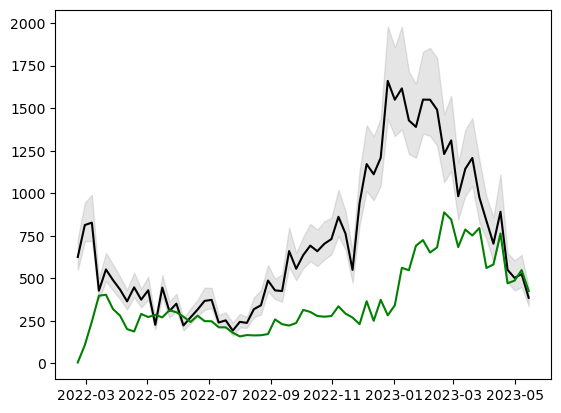

In [266]:
data = (
    final_20230626
    .reset_index()
    .groupby(['Year', 'Week'])
    [['ED_4','ED_4_max', 'ED_4_min']]
    .sum()
    .reset_index()
    .rename(columns={'ED_4':'Excess male mortality, Inheritance Data'})
    .merge(    (bmz_latest
                .assign(Year = lambda df_: df_['WebDate'].dt.isocalendar()['year'],
                        Week = lambda df_: df_['WebDate'].dt.isocalendar()['week'],)
                .groupby(['Year', 'Week'])
                ['Fio']
                .count()
                .reset_index()
                .rename(columns={'Fio':'Obituaries in social media'})
               ),
           on=['Year', 'Week']
          )
    .set_index(['Year', 'Week'])
    .pipe(replace_week_index_with_date_index)

)

fig, ax = plt.subplots()
ax.plot(data.index, data['Excess male mortality, Inheritance Data'], '-', c='black')
ax.plot(data.index, data['Obituaries in social media'], '-', c='green')
ax.fill_between(data.index, data['ED_4_min'], data['ED_4_max'], alpha=0.2, color='gray')
fig.savefig('pics/pic05.svg')

data.to_csv('pics/pic05_data.csv')

<Axes: xlabel='Date'>

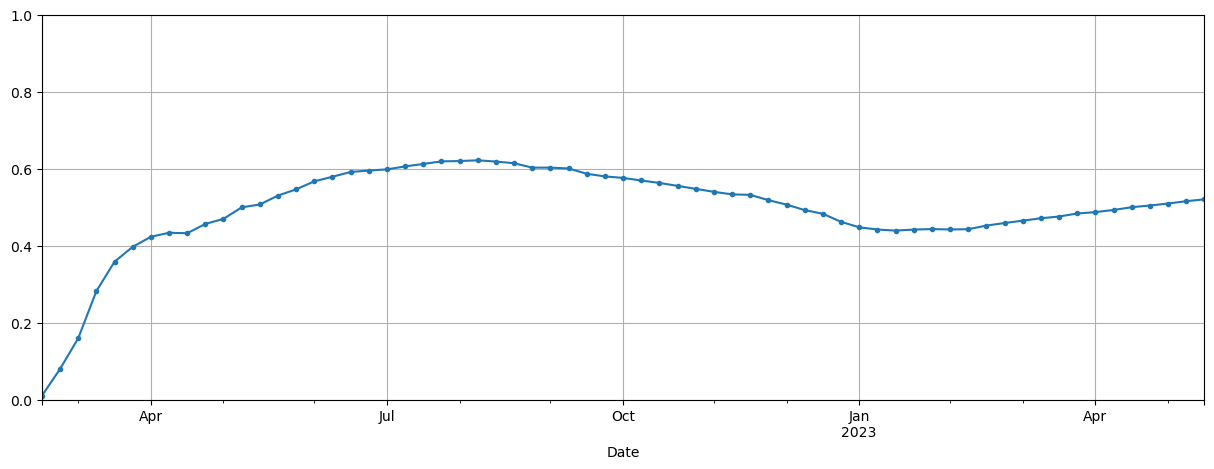

In [104]:
(
    data
    .cumsum()
    .assign(Ratio = lambda df_: df_['Obituaries in social media']/df_['Excess male mortality, Inheritance Data'])
    ['Ratio']
    .plot(figsize=(15,5), 
          grid=True,
          # title='Excess male mortality, age cohorts 15-49, Inheritance Data vs Obituaries in social media\n Year, ISO week number',
          ylim=(0,1),
          marker='.',
          # color=['black', 'green']
         )
)

#### PIc 06

In [101]:
# TODO

#### Pic 07

In [143]:
Rosstat_2022_excessive_male_mortality = pd.read_csv('etc/kobak/final_Rosstat_2022_excessive_male_mortality.csv', 
                                                    dtype={'Age':'str', 'ED_2022_Rosstat':'float'})

def redistribute_unknown_ages_in_bmz(df):
    
    return (
        df[:-1]+(
            (df[:-1] / df[:-1].sum())
            *df[-1]
                )
    )
def count_found_in_BMZ_in_2022(bmz_latest):
    return (
        bmz_latest
        .pipe(add_Age_cohort)
        .assign(Age_cohort = lambda df_: df_['Age_cohort'].astype('str').replace('nan', 'NoAgeData'))
        .assign(DeathDate = lambda df_: np.where(df_['DeathDate'].isna(),
                                                 df_['WebDate'],
                                                 df_['DeathDate'])
               )
        .loc[lambda df_: (df_['DeathDate']<'2023')]
        .groupby('Age_cohort')
        ['Fio']
        .count()
        .pipe(redistribute_unknown_ages_in_bmz)
        .reset_index()
        .rename(columns={'Fio':'FoundInBMZ', 'Age_cohort':'Age'})
    )

In [174]:
data = (
    main_df
    .loc[lambda df_: df_['Year']==2022]
    .loc[lambda df_: df_['Sex']=='m']
    .loc[lambda df_: df_['IsWar']==True]
    .assign(EC_4 = lambda df_: df_['Cases_adj']-df_['baseline_4'])
    .merge(CTD_Coefs_Apr_auto_f5, #[['Sex', 'Age', 'CTD']],
          on=['Sex','Age'], 
          how='left')
    .merge(MC_eff_df.rename(columns={'Age_cohort':'Age'}),
           on= ['Year', 'Week', 'Age'],
          )
    .assign(ED_4_max = lambda df_: (df_['EC_4']
                                    *(1/(df_['Ratio']-df_['Ratio_BE']))
                                    *df_['MC_eff']).mask(~df_['IsWar']))
    .assign(ED_4_min = lambda df_: (df_['EC_4']
                                    *(1/(df_['Ratio']+df_['Ratio_BE']))
                                    *df_['MC_eff']).mask(~df_['IsWar']))
    .assign(ED_4 = lambda df_: (df_['EC_4']*df_['CTD']*df_['MC_eff']).mask(~df_['IsWar']))
    .groupby(['Year',  'Age'])
    [['ED_4', 'ED_4_max', 'ED_4_min']]
    .sum()
    # .unstack(level=2)
    # .sum()
    .reset_index()
    .drop(columns='Year')
    .merge(Rosstat_2022_excessive_male_mortality, 
           on='Age', 
          how='outer')
    .merge(count_found_in_BMZ_in_2022(bmz_latest),
          on='Age',
          how='outer')
    .dropna(subset='ED_2022_Rosstat')
    .set_index('Age')
    .rename(columns={'ED_2022_RND':    'Inheritance data (excess male mortality), 2022',
                     'ED_2022_Rosstat':'Rosstat mortality data (excess male mortality), 2022',
                     'FoundInBMZ':     'Obituaries in social media, 2022'})
    .drop(columns=['ED_4_min', 'ED_4_max'])
    
)

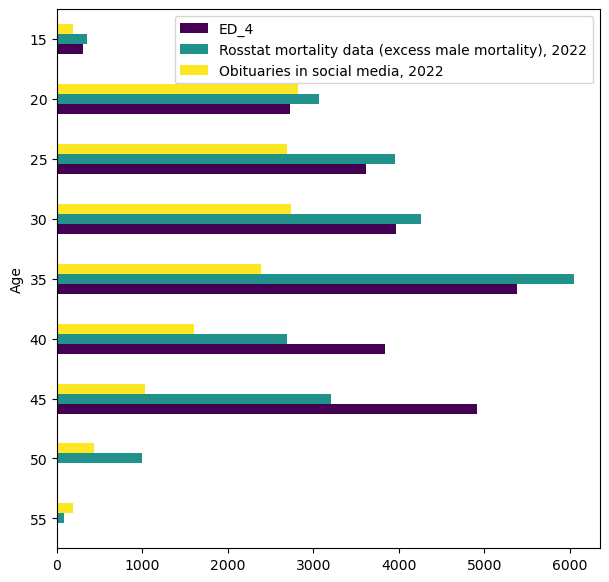

In [175]:
(
    data
    .sort_index(ascending=False)
    .plot.barh(figsize=(7,7), 
                colormap='viridis',
              # marker='.'
             )
)
data.to_csv('pics/pic07_data.csv')

#### Pic 09

In [513]:
nrows=None
years_for_tail_calculation = [2014,2015,2016,2017,2018]
data = (
    pd
    .read_parquet(parsed_table_path)
    .pipe(add_ToBeAggregated)
    .loc[lambda df_: df_['ToBeAggregated']==True]
    # .sample(1_000_00)
    [['DeathDate', 'CaseDate', 'Year']]
    .assign(DaysToCase = lambda df_: (df_.CaseDate-df_.DeathDate).dt.days+1) # NB - +1 !!
    .loc[lambda df_: df_.DaysToCase >= 0]
    .groupby(['Year','DaysToCase'])
    ['DeathDate']
    .count()
    .reset_index()
    .pivot(columns='Year', index='DaysToCase')
    ['DeathDate']
    .pipe(lambda df_: df_/df_.sum()*100)
    .head(366)
    [years_for_tail_calculation]
    
    
)

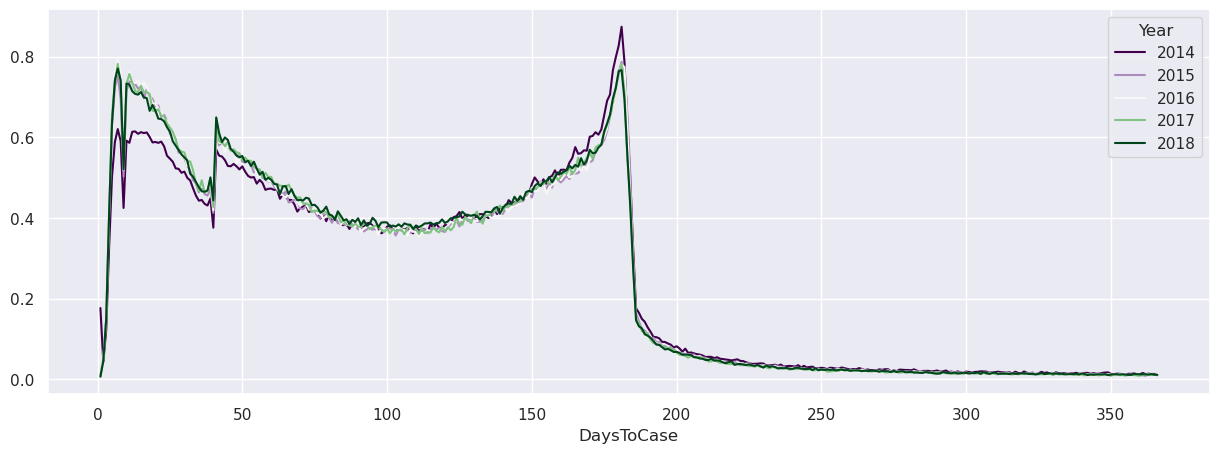

In [514]:
(
    data
    .plot(figsize=(15,5), 
          grid=True,
          colormap='PRGn'
         )
)
data.to_csv('pics/pic09_data.csv')

#### Pic 10

In [323]:
CTD_Coefs_Apr_auto_f5

Age Sex     Ratio  Ratio_BE       CTD
0         15   m  0.424242  0.168627  2.357143
1         20   m  0.570447  0.056876  1.753012
2         25   m  0.589474  0.069949  1.696429
3         30   m  0.671429  0.077805  1.489362
4         35   m      0.67  0.092162  1.492537
5         40   m    0.8125  0.110420  1.230769
6         45   m       0.8  0.202428      1.25
7  NoAgeData   m      0.62  0.040566  1.612903

In [368]:
CTD_STMF = (
    main_df
    .groupby(['Year', 'Week', 'Sex', 'Age'], as_index=False)
    ['Cases']
    .sum()
    .merge(df_STMF,
          on=['Year', 'Week', 'Sex', 'Age'],
          how='left')
    .loc[lambda df_: df_['Year']==2020]
    .loc[lambda df_: ~df_['Age'].isin(['0', '5'])]
    .groupby(['Sex', 'Age'])
    [['Cases', 'Deaths']]
    .sum()
    .assign(CaseToDeathRatio = lambda df_: df_['Cases']/df_['Deaths'],
           CaseToDeathRatio_BE = lambda df_: get_binomial_error(df_['Deaths'],df_['Cases']),
           CTD_STMF_min= lambda df_: df_['CaseToDeathRatio']-df_['CaseToDeathRatio_BE'],
           CTD_STMF_max= lambda df_: df_['CaseToDeathRatio']+df_['CaseToDeathRatio_BE'],
           )
    [['CaseToDeathRatio', 'CTD_STMF_min', 'CTD_STMF_max']]
    .reset_index()
    .rename(columns={'CaseToDeathRatio': 'Share of opened cases, general population'})

)

data = (
    CTD_Coefs_Apr_auto_f5
    [['Age', 'Sex', 'Ratio', 'Ratio_BE']]
    .assign(CTD_BMZ_min = lambda df_: df_['Ratio']-df_['Ratio_BE'],
            CTD_BMZ_max = lambda df_: df_['Ratio']+df_['Ratio_BE'])
    [['Age', 'Sex', 'Ratio', 'CTD_BMZ_min', 'CTD_BMZ_max']]
    .rename(columns={'Ratio': 'Share of opened cases, military'})
    .merge(CTD_STMF,
          on=['Age', 'Sex'],
          how='left')
    .set_index('Age')
    .drop(columns='Sex')
    .pipe(lambda df_: df_*100)
    # .plot.bar()
)
data
# data.plot.barh()
data.to_csv('pics/pic10_data.csv')

### 4.2 Additional pics

#### 4.2.1 Two dimentions of delays

In [203]:
data = (
    pd
    .read_parquet(parsed_table_path)
    .pipe(add_ToBeAggregated)
    .loc[lambda df_: df_['ToBeAggregated']==True]
    # .sample(frac=0.1)
    #     purge unknowns and irrelevant ages, get rid of categories
    .assign(Sex = lambda df_: df_['Sex'].astype('str'))
    .assign(Age = lambda df_: df_['Age'].astype('str'))
    .loc[lambda df_: (df_['Sex']!='u')&(df_['Age']!='u')]
    .loc[lambda df_: ~df_['Age'].isin(['0', '5', '10', '15'])]
    .dropna(subset='DeathActDate')
    .assign(DelayDays = lambda df_: (df_['DeathActDate']- df_['DeathDate']).dt.days)
    .assign(IsWar = lambda df_: df_['DeathDate']>='2022-02-24')
)
data

BirthDate  DeathDate DeathActDate   CaseDate          CaseIDDate  \
8324     1924-06-15 2023-05-23   2023-05-24 2023-05-24 2023-05-24 15:42:06   
8325     1925-03-16 2023-05-23   2023-05-24 2023-05-26 2023-05-26 12:34:09   
8326     1928-01-05 2023-05-23   2023-05-24 2023-05-30 2023-05-30 10:39:04   
8327     1927-12-19 2023-05-24   2023-05-24 2023-05-30 2023-05-30 15:47:08   
8328     1926-02-14 2023-05-22   2023-05-24 2023-05-31 2023-05-31 08:36:04   
...             ...        ...          ...        ...                 ...   
10163396 1989-08-02 2014-01-02   2014-01-10 2014-05-15 2016-12-03 20:55:07   
10163397 1989-05-05 2014-01-02   2014-01-10 2014-05-27 2017-02-02 16:58:29   
10163399 1991-07-24 2014-01-04   2014-01-17 2017-04-27 2017-04-28 15:23:05   
10163400 1990-02-05 2014-01-01   2014-01-06 2014-03-21 2016-12-18 22:23:32   
10163401 1992-01-13 2014-01-03   2014-01-09 2014-04-01 2016-12-17 06:47:09   

               download_time Sex  Year  Week Age  Delay  CaseWeight  \
8324     2023-06-04 15:36:43   m  2023    21  95  early    4.765167   
8325     2023-06-04 16:17:31   m  2023    21  95  early    4.765167   
8326     2023-06-04 17:18:49   m  2023    21  95  early    4.765167   
8327     2023-06-04 14:13:20   m  2023    21  95  early    4.765167   
8328     2023-06-04 13:39:25   m  2023    21  95  early    4.765167   
...                      ...  ..   ...   ...  ..    ...         ...   
10163396 2022-10-12 11:25:28   f  2014     1  20   late    1.000000   
10163397 2022-10-12 21:38:32   f  2014     1  20   late    1.000000   
10163399 2022-10-30 00:10:12   f  2014     1  20   late    1.000000   
10163400 2023-01-02 10:53:27   f  2014     1  20  early    1.000000   
10163401 2022-10-16 03:38:10   f  2014     1  20  early    1.000000   

          HasValidDeathActNumber  MyZagsID  MyZagsCount  HasMonotonousDates  \
8324                        True  97750041        269.0                True   
8325                        True  97100032       3817.0                True   
8326                       False         u          NaN                True   
8327                        True  96300008        639.0                True   
8328                        True  95600457        528.0                True   
...                          ...       ...          ...                 ...   
10163396                   False         u          NaN                True   
10163397                   False         u          NaN                True   
10163399                   False         u          NaN                True   
10163400                   False         u          NaN                True   
10163401                   False         u          NaN                True   

          ToBeAggregated  DelayDays  IsWar  
8324                True          1   True  
8325                True          1   True  
8326                True          1   True  
8327                True          0   True  
8328                True          2   True  
...                  ...        ...    ...  
10163396            True          8  False  
10163397            True          8  False  
10163399            True         13  False  
10163400            True          5  False  
10163401            True          6  False  

[9712489 rows x 19 columns]

<Axes: xlabel='Year-Week', ylabel='Sex-Age'>

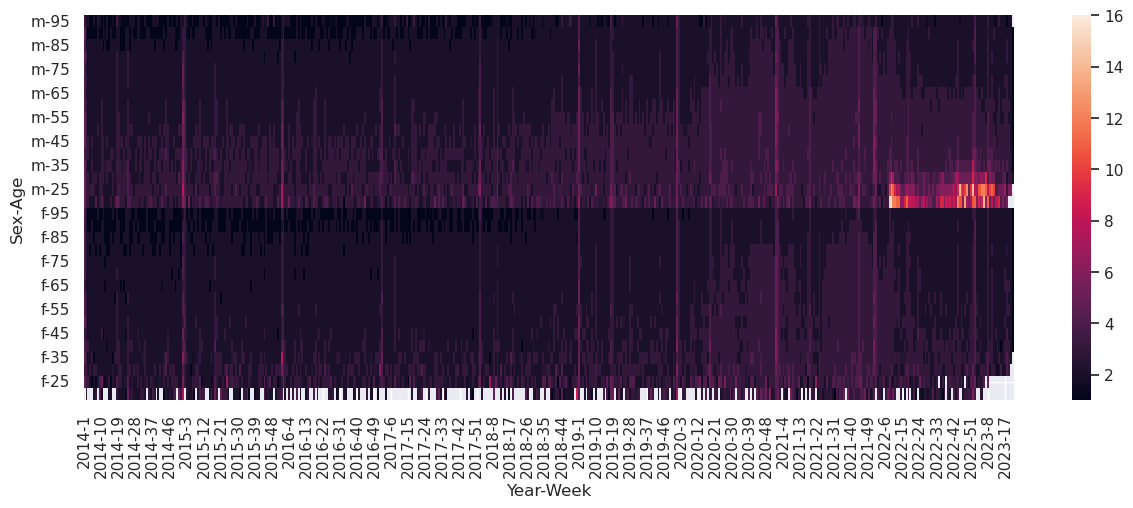

In [205]:
sns.set(rc={'figure.figsize':(15,5)})
minimal_count = 10

(
    data
    # .sample(frac=0.1)
#    Median delay by days
    .groupby(['Year', 'Week', 'Sex', 'Age'])
    .agg({'DelayDays':['count','median']})
    ['DelayDays']
    .assign(FilteredMedian = lambda df_: np.where(df_['count']>=minimal_count,
                                                  df_['median'],
                                                  np.nan))
    .unstack(level=[2, 3])
    ['FilteredMedian']
            # .pipe(lambda df_: df_/df_.loc[:'2021'].mean())
            # .pipe(lambda df_: df_.mask())
    .pipe(lambda df_: sns.heatmap(df_.transpose().sort_index(ascending=False)))
)

In [1106]:
data = (
    pd
    .read_parquet(parsed_table_path)
    .pipe(add_ToBeAggregated)
    .loc[lambda df_: df_['ToBeAggregated']==True]
    .loc[lambda df_: df_['Year'].isin([2021,2022])]
    .loc[lambda df_: df_['Age'].isin(main_age_cohorts)]
        # .loc[lambda df_: df_['Age']=='20']
    .assign(CaseDelayDays = lambda df_: (df_['CaseDate']- df_['DeathDate']).dt.days)
    .assign(ActDelayDays =  lambda df_: (df_['DeathActDate']- df_['DeathDate']).dt.days)
    [['CaseDelayDays', 'ActDelayDays', 'Year']]
)

<Axes: xlabel='Sex-Age', ylabel='Year-Week'>

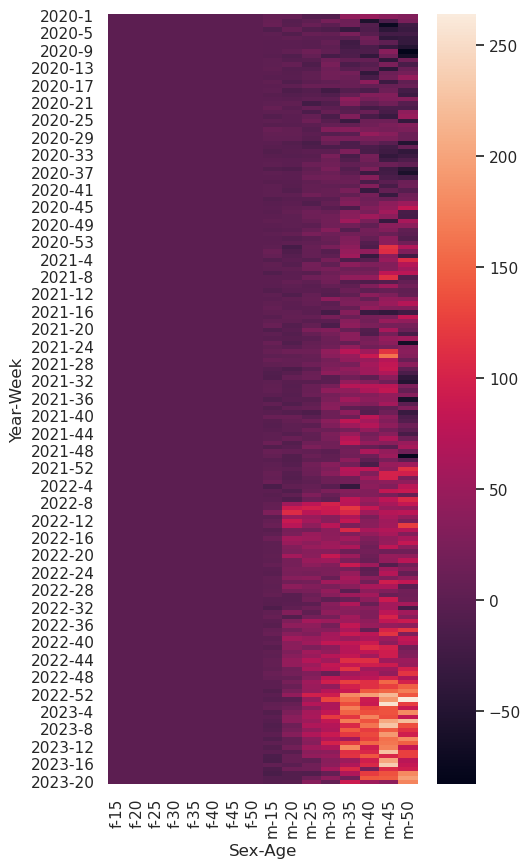

In [806]:

sns.set(rc={'figure.figsize':(5,10)})

(
    main_df
    .loc[lambda df_: df_['Age'].isin(main_age_cohorts+['50'])]
    .assign(EC_4 = lambda df_: df_['Cases_adj']-df_['baseline_4'])
    .merge(CTD_Coefs_Apr_auto_f5[['Sex', 'Age', 'CTD']],
          on=['Sex','Age'], 
          how='left')
    .merge(MC_eff_df.rename(columns={'Age_cohort':'Age'}),
           on= ['Year', 'Week', 'Age'],
           how='left'
          )
    .assign(ED_4 = lambda df_: (df_['EC_4']*df_['CTD']*df_['MC_eff']).mask(~df_['IsWar']).astype('float'))
    .groupby(['Year', 'Week', 'Sex', 'Age'])
    [['Cases', 'Cases_adj', 'baseline_4', 'EC_4', 'ED_4']]
    .sum()
    .astype('float')
    ['EC_4']
    .unstack(level=[2,3])
    .loc[2020:]
    .pipe(sns.heatmap)
)

<Axes: xlabel='Year-Week', ylabel='Age'>

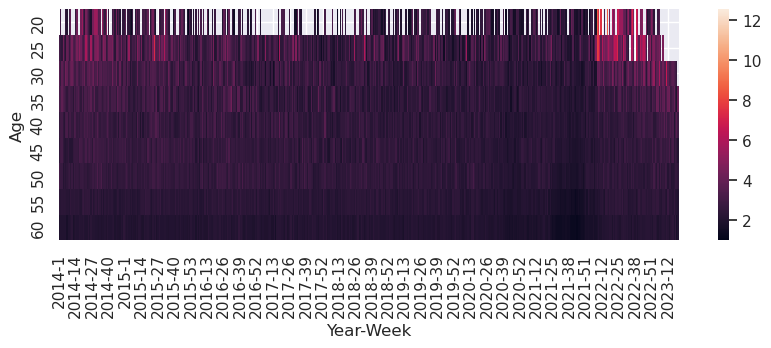

In [317]:
sns.set(rc={'figure.figsize':(10,3)})

(
    main_df
    .loc[lambda df_: df_['Age'].isin(main_age_cohorts[1:]+['50', '55', '60'])]
    .assign(EC_4 = lambda df_: df_['Cases_adj']-df_['baseline_4'])
    .merge(CTD_Coefs_Apr_auto_f5[['Sex', 'Age', 'CTD']],
          on=['Sex','Age'], 
          how='left')
    .merge(MC_eff_df.rename(columns={'Age_cohort':'Age'}),
           on= ['Year', 'Week', 'Age'],
           how='left'
          )    
    .groupby(['Year', 'Week', 'Sex', 'Age'])
    [['Cases', 'Cases_adj', 'baseline_4', 'EC_4']]
    .sum()
    ['Cases']
    .unstack(level=[2,3])
                    .pipe(lambda df_: df_.mask(df_<10))
                    # .rolling(3, center=True).mean()
    .pipe(lambda df_: df_['m']/df_['f'])
    .pipe(lambda df_: sns.heatmap(df_.transpose()))
)

<Axes: title={'center': 'Наследственные дела и смерти по STMF для мужчин 20-24'}, xlabel='Year,Week'>

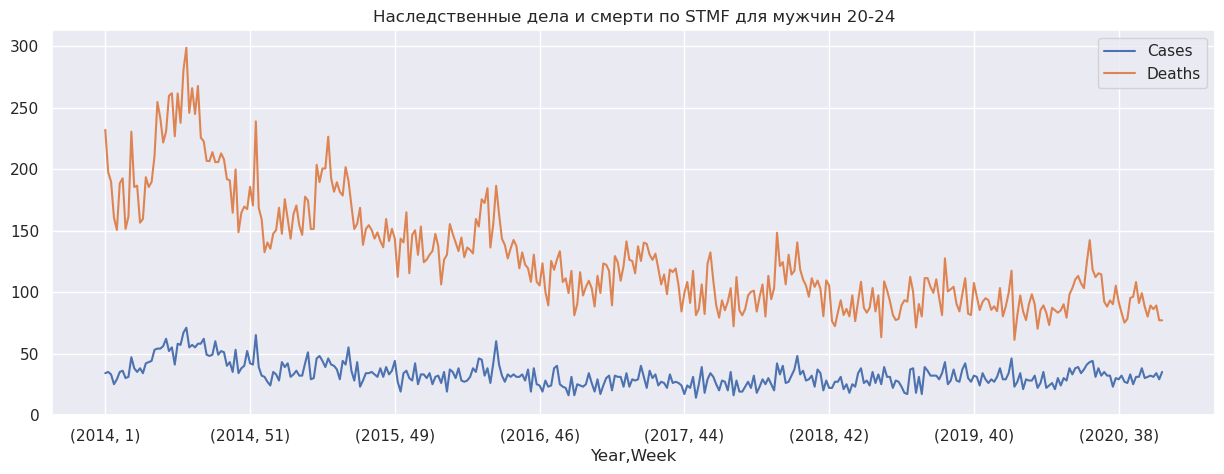

In [814]:
(
    main_df
    .groupby(['Year', 'Week', 'Sex', 'Age'], as_index=False)
    ['Cases']
    .sum()
    .merge(df_STMF,
          on=['Year', 'Week', 'Sex', 'Age'],
          how='left')
    .loc[lambda df_: (df_['Sex']=='m')&(df_['Age']=='20')]
    .set_index(['Year', 'Week'])
    .loc[:2020]
    .assign(CaseToDeathRaio = lambda df_: df_['Cases']/df_['Deaths'])
    [['Cases', 'Deaths']]
    # [['CaseToDeathRaio']]
    .plot(figsize=(15,5),
          grid=True,
      title='Наследственные дела и смерти по STMF для мужчин 20-24',
      # marker='.'
     )
)